# Import all the libraries and packages 

In [1]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting Backend To: AvailableBackends.numpy


# Get the path of all the data

In [2]:
filename_a = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp131.pkl'
filename_b = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp133.pkl'
filename_c = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp136.pkl'

# Load and get the data

In [3]:
with open(filename_a, 'rb') as myfile:
    a= joblib.load(myfile)

# Description about Hyperspectral data
## Data is obtained by scannig the core data from different boreholes using hyperspectral sensors. There were around 450 channels for each pixels initially. It was preprocessed and seperated based on 10 different types of rocks. In each of the file we have "X", "Y", "Z" coordinates points corresponding to sensors and corresponding to each rock type we have a transformed RGB correspondence information. 

(235,)
(234,)


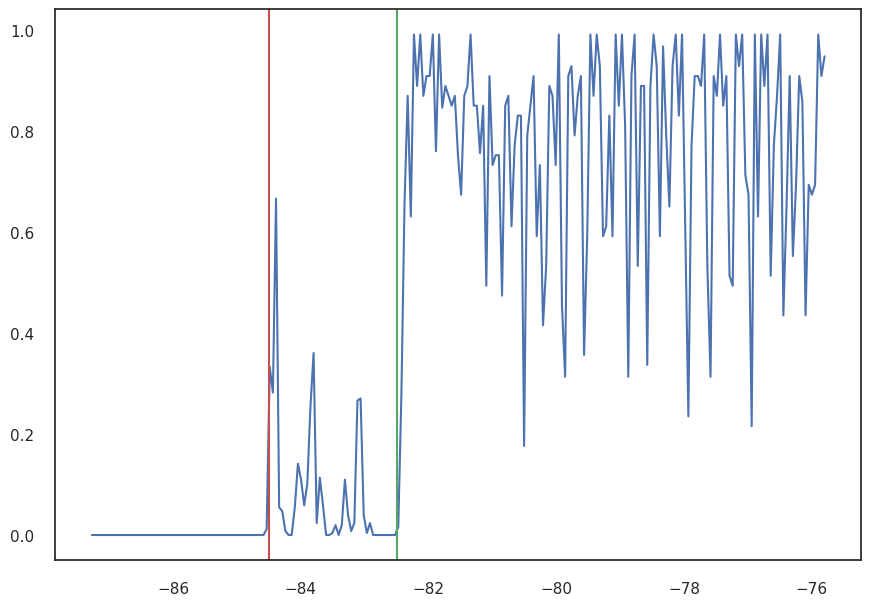

In [4]:
# The variability in "X" and "Y" are much smaller as compared to "Z" direction in case of birehole information. 
# Therefore, we are trying to build our model considering the "Z" direction mostly. 
# get the z-cordinates of borehole
zz = a['XYZ'][:,2]
print(zz.shape)
# sort the z-cordinates
ixx = np.argsort( zz )
# mask if values is less than some specified value
mask = zz[ixx] < -700
ah = a['BR_Anhydrite'][:,0] # correlates to "anhydrite index" derived from hyperspectral 
position_cord , hsi_data = zz[ixx][mask], ah[ixx][mask]/255 # To normalize the hyperspectral spectra, divide it with 255. 
plt.plot( position_cord/10 , hsi_data )
print(position_cord.shape)

# define breakpoints 
# In general it is very difficult to define the breakpoints in the plot. Prepocessing of hyperspectral data is itself a very difficult task
# becasue of high correaltion, high dimensional and noisy data. 
brk1 = -845/10 
brk2 = -825/10 

plt.axvline( brk1, color='r' )
plt.axvline( brk2, color='g')

In [5]:
hsi_data.reshape(1,-1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01176471, 0.33333333, 0.28235294, 0.66666667,
        0.05490196, 0.04705882, 0.00784314, 0.        , 0.        ,
        0.05490196, 0.14117647, 0.10980392, 0.05882353, 0.10196078,
        0.25490196, 0.36078431, 0.02352941, 0.11

# Since it is difficult to classify a hyperspectral data in general. We can apply different classical clustering methods to have some starting guess

In [6]:

#gm = KMeans(n_clusters=3, random_state=42).fit(X)
#gm = GaussianMixture(n_components=3, random_state=0).fit(X)
gm = BayesianGaussianMixture(n_components=3, random_state=0).fit(hsi_data.reshape(-1,1))

In [7]:
gm.means_ , gm.covariances_

(array([[0.4912443 ],
        [0.01853378],
        [0.86780368]]),
 array([[[0.04165404]],
 
        [[0.00509574]],
 
        [[0.01363843]]]))

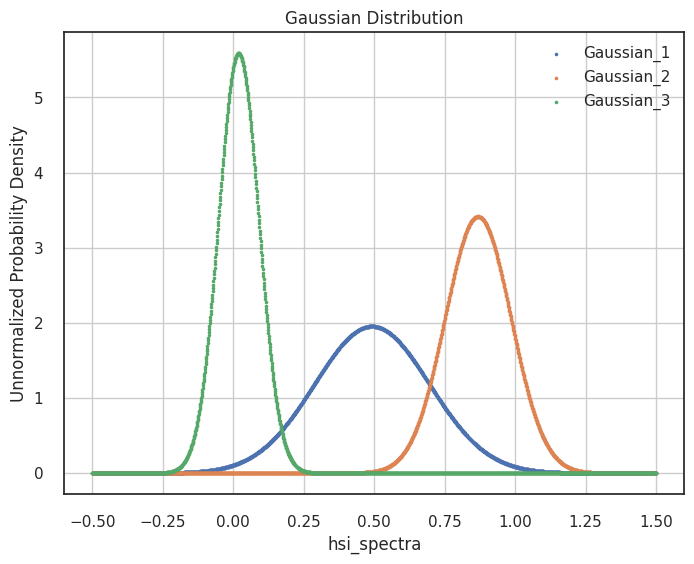

In [8]:

loc_mean_init, loc_var_init = gm.means_[[0,2,1]], np.sqrt(gm.covariances_[[0,2,1]])
# Create a grid of points
plt.figure(figsize=(8, 6))
x = np.linspace(-0.5,1.5,2000)
  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = norm(loc_mean_init[i], loc_var_init[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(x)

    # Plot the Gaussian distribution using contour plot
    
    plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('hsi_spectra')
plt.ylabel('Unnormalized Probability Density')
plt.title('Gaussian Distribution')
#plt.scatter(loc_mean[i], color='red', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
y_gmm_label = gm.predict(hsi_data.reshape(-1,1))
print(y_gmm_label)
y_gmm_label_arranged = np.zeros_like(y_gmm_label)
y_gmm_label_arranged[y_gmm_label == 1] = 3
y_gmm_label_arranged[y_gmm_label == 0] = 2
y_gmm_label_arranged[y_gmm_label == 2] = 1
y_gmm_label_arranged = torch.Tensor(y_gmm_label_arranged)
y_gmm_label_arranged 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 0 2 0 0 2 2
 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0
 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 2 0 2 2 2 0 2 2 2 0 0
 2 0 2 2 2 0 2 2 2 2 2 2]


tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 3., 1., 1., 1., 2., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1.,
        1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2.,
        1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1.,
        2., 1., 1., 1., 2., 2., 1., 2., 

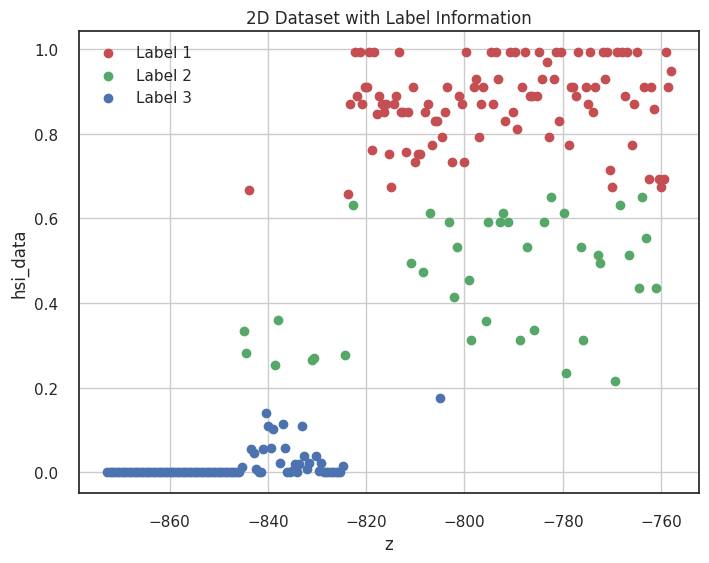

In [10]:
import matplotlib.pyplot as plt
# Define colors for each label
colors = ['r', 'g', 'b']
labels = y_gmm_label_arranged

# Plot the dataset with different colors for each label
plt.figure(figsize=(8, 6))
for label_val, color in zip([1,2,3], colors):
    plt.scatter(position_cord[labels == label_val], hsi_data[labels == label_val], c=color, label=f'Label {label_val}')

plt.xlabel('z')
plt.ylabel('hsi_data')
plt.title('2D Dataset with Label Information')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# A = np.zeros_like(a['BR_Anhydrite'][:, 0])
# B = np.zeros_like(a['BR_Anhydrite'][:, 0])
# C = np.zeros_like(a['BR_Anhydrite'][:, 0])

A = np.zeros_like(hsi_data)
B = np.zeros_like(hsi_data)
C = np.zeros_like(hsi_data)

# Get indices where the mask is True
# indices_A = np.where(mask & (zz[ixx] < brk1))
# indices_B = np.where(mask & (zz[ixx] > brk1) & (zz[ixx] < brk2))
# indices_C = np.where(mask & (zz[ixx] > brk2))
shift =0
# Get indices where the mask is True
indices_A = np.where(mask & (zz[ixx] < (brk1+shift)))
indices_B = np.where(mask & (zz[ixx] > (brk1+shift)) & (zz[ixx] < (brk2+shift)))
indices_C = np.where(mask & (zz[ixx] > (brk2+shift)))

y_obs_label = torch.ones(234)
y_obs_label[indices_A] =3
y_obs_label[indices_B] = 2
y_obs_label

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 

In [12]:
matched_label = y_obs_label == y_gmm_label_arranged
(matched_label.sum()/len(y_obs_label)) *100

tensor(39.7436)

# We use the normalised hsi data y_obs_label information

In [13]:

y_obs_label = hsi_data.reshape((-1,1))
y_obs_label

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

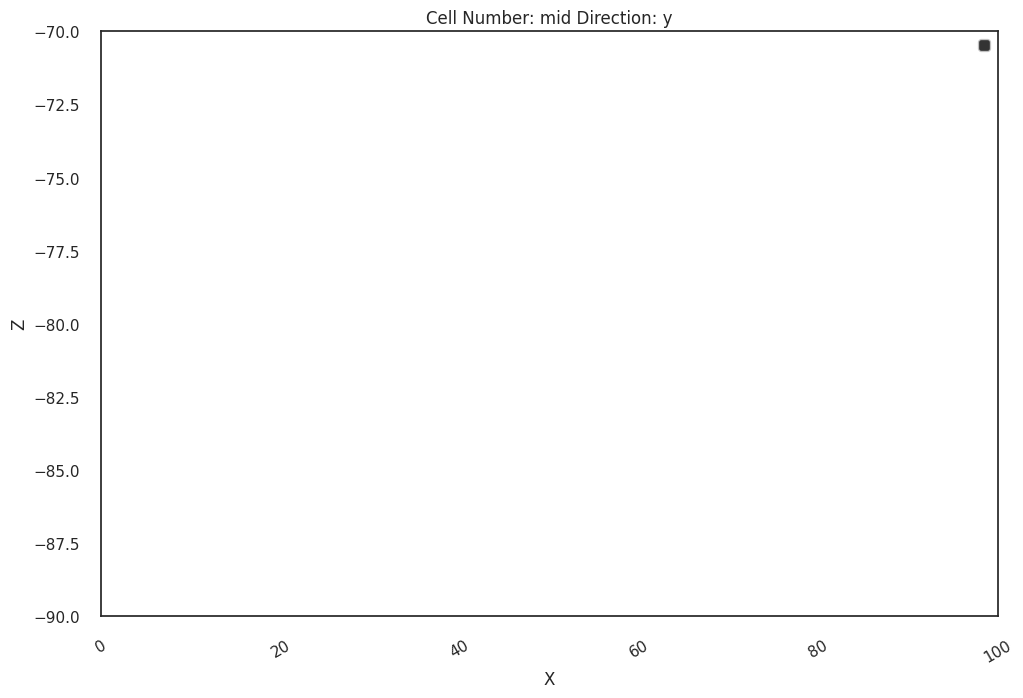

In [14]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 100, -50, 50, -90, -70],
    resolution=[100,100,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
p2d = gpv.plot_2d(geo_model_test)

In [15]:
geo_model_test.grid.active_grids_bool

array([False, False, False, False, False])

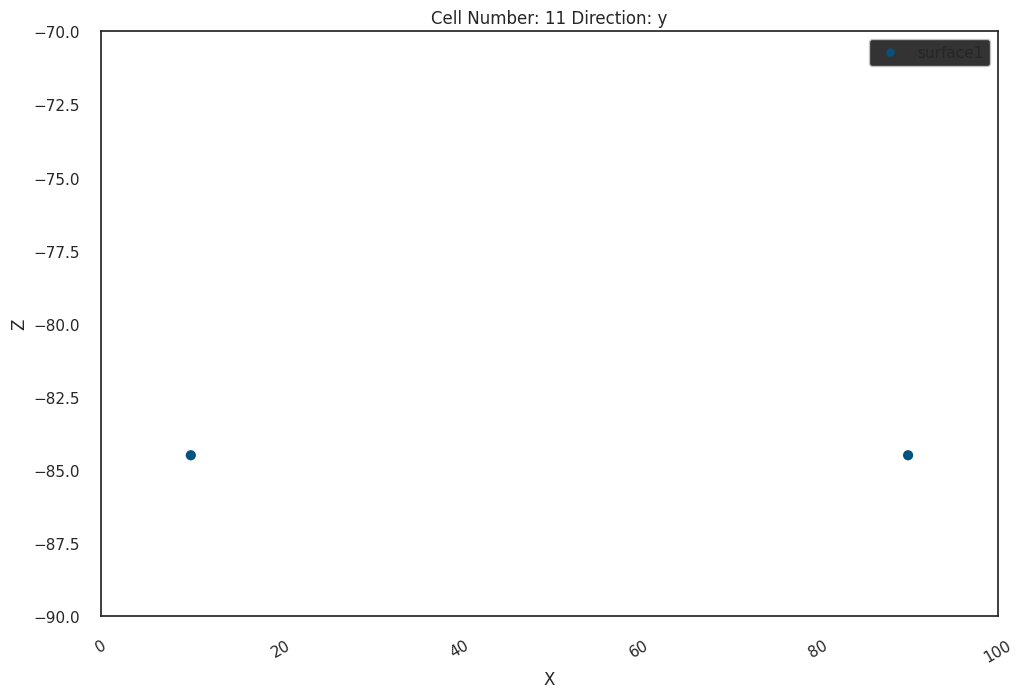

In [16]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[10.0, 90.0],
    y=[0.0, 0.0],
    z=[brk1, brk1],
    elements_names=['surface1', 'surface1']
)

gpv.plot_2d(geo_model_test, cell_number=11)

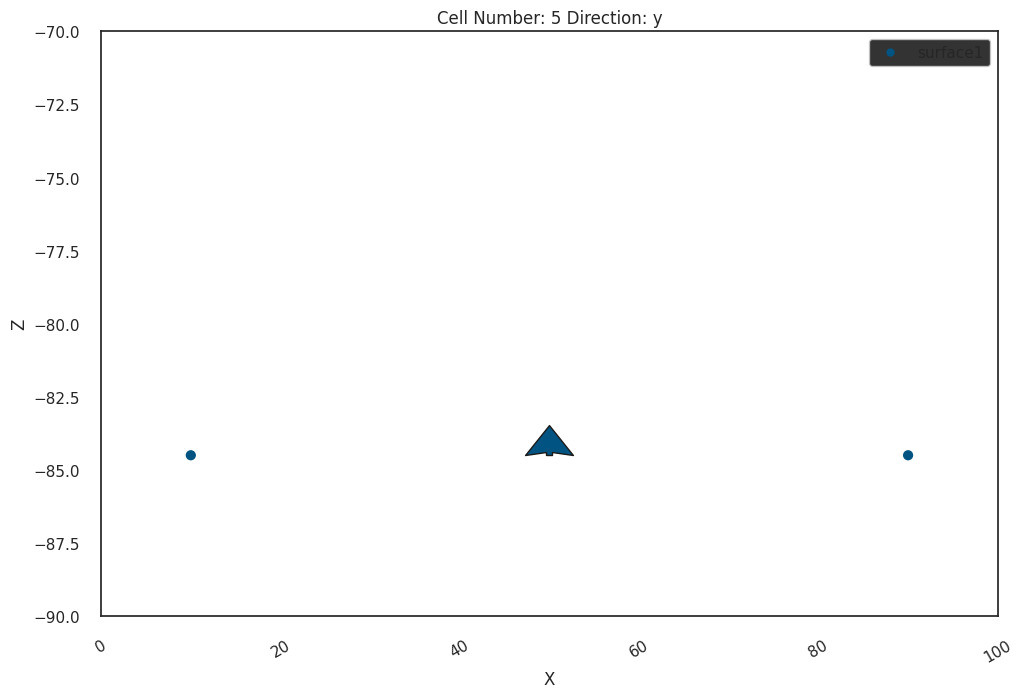

In [17]:
gp.add_orientations(
    geo_model=geo_model_test,
    x=[50],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1]]
)

gpv.plot_2d(geo_model_test, cell_number=5)

In [18]:
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

In [19]:
gp.compute_model(geo_model_test, engine_config=gp.data.GemPyEngineConfig())

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Solutions(3 Octree Levels, 1 DualContouringMeshes)

In [20]:
geo_model_test.interpolation_options.kernel_options

KernelOptions(range=5, c_o=10, uni_degree=1, i_res=4, gi_res=2, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, compute_condition_number=False, kernel_solver=Solvers.DEFAULT)

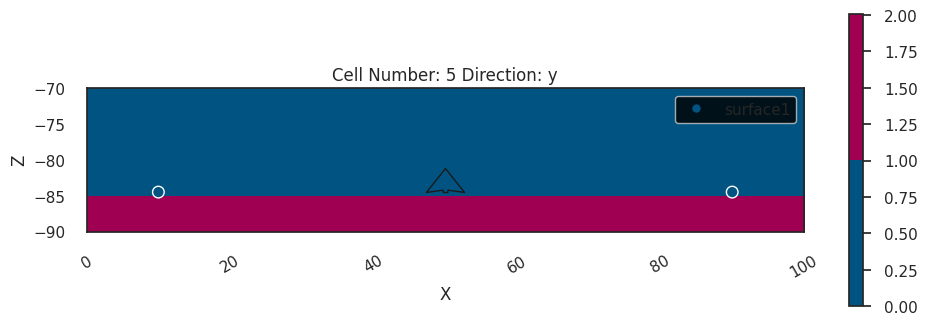

In [21]:
gpv.plot_2d(geo_model_test, cell_number=[5])

In [22]:
#gpv.plot_3d(geo_model_test, show_surfaces=True, image=True)

In [23]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

Setting Backend To: AvailableBackends.numpy


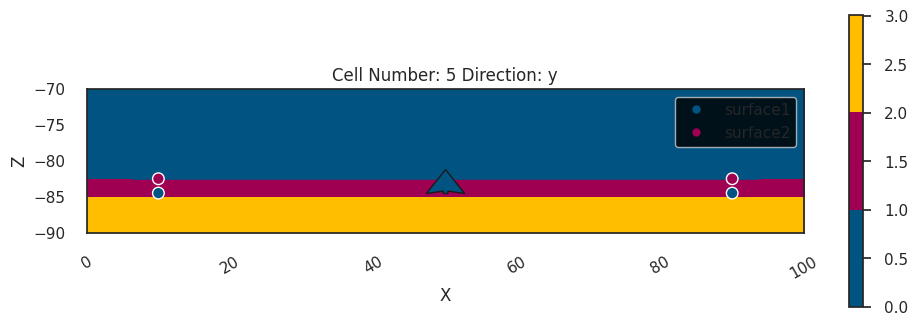

In [24]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([10.0, 90.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([brk2, brk2]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)
# Compute and visualize the updated model:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    

In [25]:
#gpv.plot_3d(geo_model_test, image=True)

In [26]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
),
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [27]:
geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

In [28]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
),
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

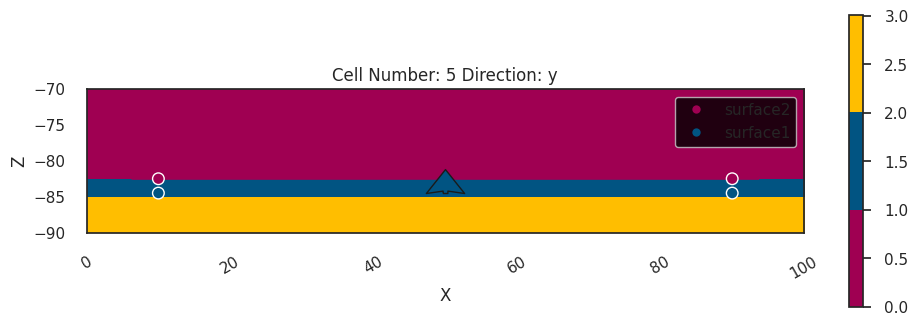

In [29]:
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

# Create a custome grid where the observed data information is available 

In [30]:
x_loc = 30
y_loc = 0
z_loc = position_cord
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

Active grids: ['custom']


In [31]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5]])

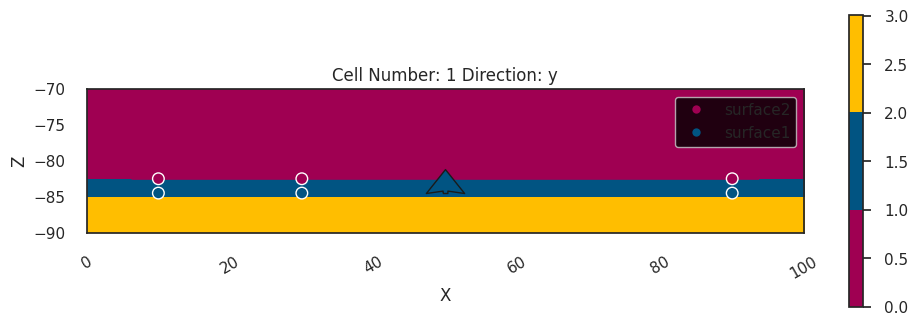

In [32]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[x_loc, x_loc],
    y=[0.0, 0.0],
    z=[brk1, brk2],
    elements_names=['surface1', 'surface2']
)
gpv.plot_2d(geo_model_test, cell_number=1)

In [33]:
geo_model_test.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,1530544,0.00
90.00,0.00,-82.50,1530544,0.00
30.00,0.00,-82.50,1530544,0.00
10.00,0.00,-84.50,55324955,0.00
90.00,0.00,-84.50,55324955,0.00
30.00,0.00,-84.50,55324955,0.00


Setting Backend To: AvailableBackends.numpy


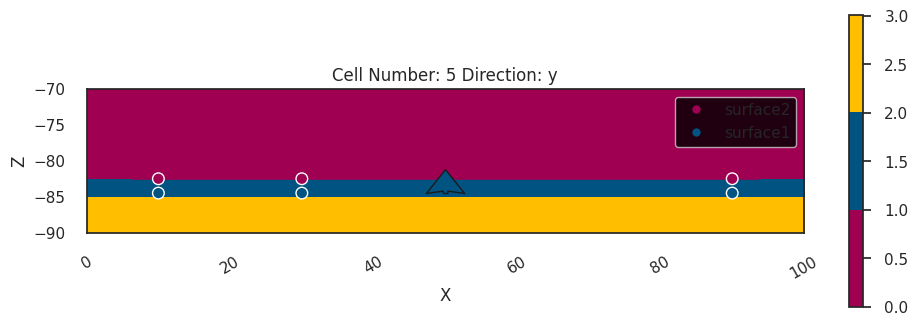

In [34]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [35]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 30. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5],
       [ 30. ,   0. , -84.5]])

In [36]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [37]:
geo_model_test.interpolation_options.uni_degree = 0
geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 1100.
geo_model_test.interpolation_options.kernel_options.range=5.0

In [38]:
#geo_model_test.solutions.octrees_output[0].last_output_center

In [39]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values.shape

(234,)

In [40]:
y_obs_label.shape

(234, 1)

In [41]:
geo_model_test.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,1530544,0.00
90.00,0.00,-82.50,1530544,0.00
30.00,0.00,-82.50,1530544,0.00
10.00,0.00,-84.50,55324955,0.00
90.00,0.00,-84.50,55324955,0.00
30.00,0.00,-84.50,55324955,0.00


In [42]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
50.00,0.00,-84.50,0.00,0.00,1.00,55324955,0.01


In [43]:
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-0.25    0.      0.0125]
 [ 0.25    0.      0.0125]
 [-0.125   0.      0.0125]
 [-0.25    0.      0.    ]
 [ 0.25    0.      0.    ]
 [-0.125   0.      0.    ]]


array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 30. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5],
       [ 30. ,   0. , -84.5]])

Condition number: 49283.35085932725.
Condition number: 49283.35085932725.


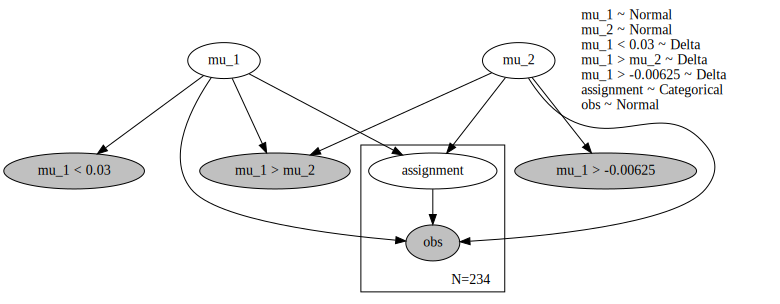

In [44]:
y_obs_label = torch.tensor(y_obs_label,dtype=torch.float64)


@config_enumerate
def model_test(obs_data):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[2, 2]
    prior_mean_surface_2 = sp_coords_copy_test[5, 2]
    
    

    
    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.00625, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.00625, dtype=torch.float64)))
    
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0.03', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 <0.03))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_1 > -0.00625', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > -0.00625))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([2]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_2
    )
    
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    lambda_ = 5
    #class_label = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    z_nk = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    N_k = torch.sum(z_nk,axis=0)
    N = len(custom_grid_values)
    pi_k = N_k /N
    mean = []
    cov = []
    #print("Z_nk",z_nk.shape)
    for i in range(z_nk.shape[1]):
            mean_k = torch.sum( z_nk[:,i][:,None] * obs_data, axis=0)/ N_k[i]
            #print("mean_k",mean_k.shape[0])
            #cov_k = torch.sum( (normalised_hsi - mean_k.reshape((-1,1))) (normalised_hsi - mean_k).T )
            cov_k = torch.tensor(0.0,dtype=torch.float64)
            for j in range(z_nk.shape[0]):
                 #cov_k +=  z_nk[j,i]* torch.matmul((obs_data[j,:] - mean_k).reshape((-1,1)) ,(obs_data[j,:] - mean_k).reshape((1,-1)))
                 cov_k +=  z_nk[j,i]* (obs_data[j,:] - mean_k)[0] * (obs_data[j,:] - mean_k)[0]
            mean.append(mean_k)
            cov_k=cov_k/N_k[i] #+ 1e-3 * torch.diag(torch.ones(cov_k.shape[0],dtype=torch.float64))
            cov.append(cov_k)
    mean_tensor = torch.stack(mean, dim=0).reshape(-1)
    cov_tensor = torch.stack(cov,dim=0)
    #print(mean_tensor.shape, cov_tensor.shape, obs_data.shape)
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(pi_k))
        #print(mean_tensor[assignment].shape, cov_tensor[assignment].shape)
        obs = pyro.sample("obs", dist.Normal(mean_tensor[assignment], torch.sqrt(cov_tensor[assignment]) ), obs=obs_data.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(y_obs_label,))
pyro.render_model(model_test, model_args=(y_obs_label,),render_distributions=True)

In [45]:
print(y_obs_label.shape)
# model_test(y_obs_label)

torch.Size([234, 1])


Condition number: 49283.35085932725.
Condition number: 51776.38788381513.
Condition number: 23519.085393956695.
Condition number: 54278.438307464625.
Condition number: 27535.00718330347.
Condition number: 52963.2322427669.
Condition number: 54442.31418363474.
Condition number: 50970.736814738775.
Condition number: 43985.60096348545.
Condition number: 42616.32867758147.
Condition number: 48476.69415407939.
Condition number: 54485.83271157278.
Condition number: 40580.28033316609.
Condition number: 54575.55541909034.
Condition number: 52393.56960879297.
Condition number: 42067.85919839821.
Condition number: 39129.03109422014.
Condition number: 27428.600429466835.
Condition number: 41515.86989005974.
Condition number: 49593.240061386576.
Condition number: 54095.77761062653.
Condition number: 21310.953157518303.
Condition number: 49485.59200408061.
Condition number: 32076.072983872255.
Condition number: 50145.15801080502.
Condition number: 54458.883601110465.
Condition number: 39649.8272184

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


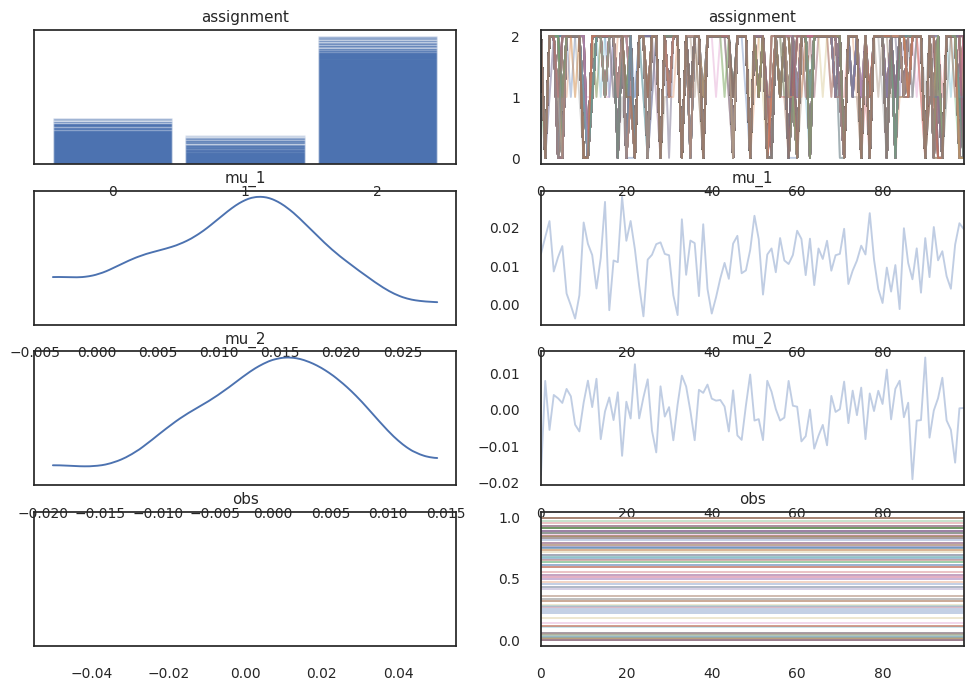

: 

In [46]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = ['mu_1 > mu_2','mu_1 < 0.03','mu_1 > -0.00625']

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [47]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/150 [00:00, ?it/s]

Condition number: 52108.8652561194.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 133777.8544864813.
Condition number: 52007.342764725225.
Condition number: 23817.370745478187.
Condition number: 52007.342764725225.
Condition number: 50043.696517004195.
Condition number: 52007.342764725225.
Condition number: 51075.870401792235.
Condition number: 52007.342764725225.
Condition number: 52614.13189271182.
Condition number: 52007.342764725225.
Condition number: 52281.06496676522.
Condition number: 52007.342764725225.
Condition number: 52005.32814818649.
Condition number: 52007.342764725225.
Condition number: 52065.19592188378.
Condition number: 52007.342764725225.
Condition number: 52098.03161582606.
Condition number: 52029.78370364032.
Condition number: 52056.4387775319.
Condition number: 52086.81853742251.
Condition number: 51989.

Warmup:   1%|          | 1/150 [00:01,  1.93s/it, step size=3.05e-04, acc. prob=0.853]

Condition number: 51953.35679098845.
Condition number: 52068.2667630401.
Condition number: 52078.22466795549.
Condition number: 51468.05387461595.
Condition number: 50791.03802859959.
Condition number: 50051.513494909064.
Condition number: 49255.04057062319.
Condition number: 48408.266098166685.


Warmup:   1%|▏         | 2/150 [00:02,  1.16s/it, step size=3.56e-05, acc. prob=0.426]

Condition number: 47518.74159531107.
Condition number: 46594.707982698455.
Condition number: 45644.86032078066.
Condition number: 52096.48816415582.
Condition number: 52054.711087548574.
Condition number: 52058.18677320013.
Condition number: 52059.95519988307.
Condition number: 52061.74399020648.
Condition number: 52063.552896216555.
Condition number: 52065.38147509909.
Condition number: 52067.22909070704.
Condition number: 52053.00337934768.
Condition number: 52051.31513530693.
Condition number: 52049.645610784384.
Condition number: 52047.99383179804.
Condition number: 52046.35857258891.


Warmup:   3%|▎         | 4/150 [00:03,  1.36it/s, step size=2.26e-06, acc. prob=0.463]

Condition number: 52044.73834273974.
Condition number: 52043.131346604074.
Condition number: 52041.53549170288.
Condition number: 52040.617781048335.
Condition number: 52038.11242392022.
Condition number: 52035.61435212253.
Condition number: 52045.65389616005.
Condition number: 52048.18606394283.
Condition number: 52050.72833996812.
Condition number: 52053.2810803794.
Condition number: 52033.12249540682.
Condition number: 52030.6356374616.
Condition number: 52028.15241716708.
Condition number: 52025.67133866138.
Condition number: 52023.190777664226.
Condition number: 52020.70899624319.
Condition number: 52018.22416775293.
Condition number: 52015.73438952148.
Condition number: 52013.23772786314.
Condition number: 52010.732237678756.
Condition number: 52008.21600549411.
Condition number: 52005.6871926973.
Condition number: 52003.144061295825.
Condition number: 52000.58503654754.
Condition number: 51998.0087256322.
Condition number: 51995.413961933016.
Condition number: 51992.79982298544.

Warmup:   3%|▎         | 5/150 [01:06, 19.91s/it, step size=2.45e-06, acc. prob=0.571]

Condition number: 49133.61972176282.
Condition number: 49131.35832868878.
Condition number: 49130.089741036594.
Condition number: 49128.74165341253.
Condition number: 49127.324865176604.
Condition number: 49125.85105524901.
Condition number: 49124.33250961022.
Condition number: 49134.59751173045.
Condition number: 49135.46614967044.
Condition number: 49136.22252294337.
Condition number: 49136.86547191546.
Condition number: 49137.39580597802.


Warmup:   4%|▍         | 6/150 [01:07, 14.08s/it, step size=2.91e-06, acc. prob=0.642]

Condition number: 49137.81628963551.
Condition number: 49138.13156926169.
Condition number: 49138.348063034195.
Condition number: 49122.53129206602.
Condition number: 49132.03654205702.
Condition number: 49136.67427059939.
Condition number: 49117.649582823775.
Condition number: 49112.67539940354.
Condition number: 49107.60644952083.
Condition number: 49102.44255078104.
Condition number: 49141.247469188704.
Condition number: 49145.766743738095.
Condition number: 49150.2435941485.
Condition number: 49154.690097280974.
Condition number: 49159.118609385834.
Condition number: 49163.54146734116.
Condition number: 49167.970732832.
Condition number: 49172.417947255235.
Condition number: 49176.89394365729.
Condition number: 49181.40867312611.
Condition number: 49185.971084039054.
Condition number: 49190.58901629561.
Condition number: 49195.269142443154.
Condition number: 49200.016905265744.
Condition number: 49204.836497580145.
Condition number: 49209.730841582066.
Condition number: 49214.70157

Warmup:   5%|▍         | 7/150 [02:09, 28.92s/it, step size=3.67e-06, acc. prob=0.693]

Condition number: 52241.20550609585.
Condition number: 52241.25793736087.
Condition number: 52241.29424038524.
Condition number: 52241.18705499355.
Condition number: 52241.17169278966.
Condition number: 52241.157510166304.
Condition number: 52241.142380668745.
Condition number: 52241.12402932145.
Condition number: 52241.10010439077.
Condition number: 52241.06828413212.
Condition number: 52241.02634788015.
Condition number: 52240.972295231026.
Condition number: 52240.90443218891.
Condition number: 52240.82145170105.
Condition number: 52240.72250766017.
Condition number: 52241.338231541915.


Warmup:   5%|▌         | 8/150 [02:10, 20.46s/it, step size=4.81e-06, acc. prob=0.732]

Condition number: 52241.3901731394.
Condition number: 52233.3885178738.
Condition number: 52225.83008956341.
Condition number: 52218.2250241385.
Condition number: 52248.38355813138.
Condition number: 52255.83265689223.
Condition number: 52263.25894769592.
Condition number: 52270.669534072964.
Condition number: 52278.070944867955.
Condition number: 52285.46878664259.
Condition number: 52292.86751295212.
Condition number: 52300.27030780123.
Condition number: 52307.67904321603.
Condition number: 52315.09428658405.
Condition number: 52322.51534707306.
Condition number: 52329.94033952229.
Condition number: 52210.57121567832.
Condition number: 52202.86884349319.
Condition number: 52195.12038435607.
Condition number: 52187.33041994544.
Condition number: 52179.50524119926.
Condition number: 52171.652324530834.
Condition number: 52163.77974078817.
Condition number: 52155.895578042226.
Condition number: 52148.00744229062.
Condition number: 52140.12204219511.
Condition number: 52132.244887006316.

Warmup:   6%|▌         | 9/150 [03:13, 33.25s/it, step size=6.45e-06, acc. prob=0.761]

Condition number: 40944.86031951671.
Condition number: 40929.502161272016.
Condition number: 40914.09236997559.
Condition number: 46580.43496572778.
Condition number: 46546.929672249506.
Condition number: 46515.079965226665.
Condition number: 46650.34356193444.
Condition number: 46685.09390499768.
Condition number: 46718.26487746254.
Condition number: 46748.7943205146.
Condition number: 46775.91653991162.
Condition number: 46799.27584062233.
Condition number: 46818.944097511696.
Condition number: 46835.41471935146.
Condition number: 46849.560742269.
Condition number: 46862.482282269164.
Condition number: 46875.25775524522.
Condition number: 46888.747627583994.
Condition number: 46485.17057144818.
Condition number: 46457.37161339554.
Condition number: 46431.77848103851.
Condition number: 46408.434604477436.
Condition number: 46387.34023697651.
Condition number: 46368.44870359657.
Condition number: 46351.64933805306.
Condition number: 46336.734317597584.
Condition number: 46323.345938314

Warmup:   7%|▋         | 10/150 [03:31, 28.46s/it, step size=8.06e-06, acc. prob=0.782]

Condition number: 50744.47586171902.
Condition number: 48465.3118004244.
Condition number: 48427.12041802003.
Condition number: 48391.34086421711.
Condition number: 48548.78756948367.
Condition number: 48593.80470991126.
Condition number: 48640.59249523357.
Condition number: 48688.48109187603.
Condition number: 48736.31630769769.
Condition number: 48782.494506977375.
Condition number: 48825.472495111.
Condition number: 48864.3529319637.
Condition number: 48899.04613626308.
Condition number: 48930.24961108693.
Condition number: 48959.35307196699.
Condition number: 48987.97309069307.
Condition number: 49017.355903267555.
Condition number: 49048.21979929615.
Condition number: 49080.911757035974.
Condition number: 49115.57400591409.
Condition number: 49152.24218832538.
Condition number: 49190.88922636225.
Condition number: 49231.43047066783.
Condition number: 49273.69284374682.
Condition number: 49317.33844762567.
Condition number: 49361.73015610022.
Condition number: 49405.79237084958.
Co

Warmup:   7%|▋         | 11/150 [04:27, 36.86s/it, step size=1.10e-05, acc. prob=0.802]

Condition number: 35989.83849387915.
Condition number: 35952.740643782156.
Condition number: 35916.301030212926.
Condition number: 35883.48529181351.
Condition number: 35861.132201701046.
Condition number: 35852.52622250827.
Condition number: 35859.07618859176.
Condition number: 35881.26764102692.
Condition number: 35919.02778868719.
Condition number: 35971.67114105222.
Condition number: 36037.40038541357.
Condition number: 36112.1601252544.
Condition number: 36187.89965191186.
Condition number: 36252.45832467964.
Condition number: 36294.47226027322.
Condition number: 36308.59921179071.
Condition number: 36296.497827729516.
Condition number: 36266.68551382562.
Condition number: 36231.70187132309.
Condition number: 36201.97201841552.
Condition number: 36183.40208836056.
Condition number: 36178.76238340839.
Condition number: 36189.21568882353.
Condition number: 36215.12081528048.
Condition number: 36256.30505854048.
Condition number: 36311.935115918095.
Condition number: 36379.9250324677

Warmup:   8%|▊         | 12/150 [04:33, 27.53s/it, step size=1.37e-05, acc. prob=0.816]

Condition number: 34844.29905166472.
Condition number: 34823.23464848529.
Condition number: 35233.11449668352.
Condition number: 35299.1377724768.
Condition number: 35367.551085835956.
Condition number: 35453.35799053716.
Condition number: 35542.19968245568.
Condition number: 35608.991980334176.


Warmup:   9%|▊         | 13/150 [04:33, 19.38s/it, step size=1.80e-05, acc. prob=0.829]

Condition number: 35633.52740447127.
Condition number: 35374.73291208452.
Condition number: 35474.86646312102.
Condition number: 35552.891093934406.


Warmup:   9%|▉         | 14/150 [04:34, 13.65s/it, step size=2.28e-05, acc. prob=0.839]

Condition number: 35263.55673624256.
Condition number: 35271.44070573924.
Condition number: 35391.019340948435.
Condition number: 35523.282085903935.


Warmup:  10%|█         | 15/150 [04:34,  9.61s/it, step size=2.18e-05, acc. prob=0.841]

Condition number: 35490.6988742827.
Condition number: 35449.70131434824.
Condition number: 35354.549396758055.
Condition number: 35290.209803860205.
Condition number: 35522.77996124936.
Condition number: 35469.75309457199.
Condition number: 35427.54087085339.
Condition number: 35428.521189538704.
Condition number: 35479.19103716128.
Condition number: 35568.84265189286.
Condition number: 35657.01230228061.
Condition number: 35681.67396627273.


Warmup:  11%|█         | 16/150 [04:34,  6.92s/it, step size=3.02e-05, acc. prob=0.851]

Condition number: 35443.21196289499.
Condition number: 35517.00974777159.
Condition number: 35600.371518004635.
Condition number: 35388.99126986163.
Condition number: 35298.93439088051.
Condition number: 35221.14457493692.
Condition number: 35180.57740260234.
Condition number: 35155.52937671171.
Condition number: 35096.689412336455.
Condition number: 35006.798480468235.
Condition number: 34935.67954497948.
Condition number: 34901.99497504922.
Condition number: 34876.93655388831.
Condition number: 34812.45162735154.
Condition number: 34723.92481473414.
Condition number: 35689.85381052774.
Condition number: 35740.5997766199.
Condition number: 35769.65036585922.
Condition number: 35823.250110078305.
Condition number: 35911.26238205626.
Condition number: 35999.77790743455.
Condition number: 36048.13493154268.
Condition number: 36080.358919902996.
Condition number: 36139.912612281325.
Condition number: 36231.83264967616.
Condition number: 36319.21812399241.
Condition number: 36366.127978067

Warmup:  11%|█▏        | 17/150 [05:00, 12.65s/it, step size=3.67e-05, acc. prob=0.858]

Condition number: 44106.02641395618.
Condition number: 44100.720482165336.
Condition number: 43885.82057377244.
Condition number: 43767.27793070612.


Warmup:  12%|█▏        | 18/150 [05:01,  8.98s/it, step size=3.12e-06, acc. prob=0.814]

Condition number: 43761.075761174536.
Condition number: 43828.58143048454.
Condition number: 43606.01266434965.
Condition number: 44079.48446525682.
Condition number: 44095.24422010511.
Condition number: 44103.46084847418.
Condition number: 44071.961642359325.
Condition number: 44064.68459147126.
Condition number: 44057.65473534238.
Condition number: 44050.86999097399.
Condition number: 44044.32475754038.
Condition number: 44038.00992276919.
Condition number: 44031.91287767374.
Condition number: 44026.01755281424.
Condition number: 44020.30447466092.
Condition number: 44014.75087437334.
Condition number: 44009.33084360275.
Condition number: 44004.0155654622.
Condition number: 44111.88270163114.
Condition number: 44120.49110502857.
Condition number: 44129.26412360669.
Condition number: 44138.17670912052.
Condition number: 44147.20091582526.
Condition number: 44156.306193496355.
Condition number: 44165.45976163276.
Condition number: 44174.62709062865.
Condition number: 44183.77247063646.

Warmup:  13%|█▎        | 19/150 [06:04, 25.16s/it, step size=4.38e-06, acc. prob=0.824]

Condition number: 38126.35120998941.
Condition number: 40359.194045822376.
Condition number: 40383.378572724076.
Condition number: 40394.86638404497.
Condition number: 40405.8876655171.
Condition number: 40416.41488004074.
Condition number: 40426.43826284044.
Condition number: 40435.96627421744.
Condition number: 40445.02518361061.
Condition number: 40453.6578392947.
Condition number: 40461.92169441203.
Condition number: 40469.886237914005.
Condition number: 40477.63000791512.
Condition number: 40485.237388744405.
Condition number: 40492.7953767831.
Condition number: 40500.39051167328.
Condition number: 40508.10608615879.
Condition number: 40516.01974196102.
Condition number: 40524.201486531536.
Condition number: 40532.71211838473.
Condition number: 40541.60204366932.
Condition number: 40550.91043836698.
Condition number: 40560.66465269677.
Condition number: 40570.87987878982.
Condition number: 40581.558957579495.
Condition number: 40592.69237726047.
Condition number: 40604.25838447028

Warmup:  13%|█▎        | 20/150 [07:06, 36.43s/it, step size=6.11e-06, acc. prob=0.833]

Condition number: 47606.521366085806.
Condition number: 47617.83643947826.
Condition number: 47628.902538690556.
Condition number: 42915.19308123705.
Condition number: 42898.963480670194.
Condition number: 42882.76385570312.
Condition number: 42948.31702177579.
Condition number: 42965.453983206535.
Condition number: 42983.09368795811.
Condition number: 43001.287838320124.
Condition number: 43020.05523070469.
Condition number: 43039.38114431202.
Condition number: 43059.21796957065.
Condition number: 43079.48712389317.
Condition number: 43100.08243376793.
Condition number: 43120.87522858262.
Condition number: 43141.72132490637.
Condition number: 43162.46985940038.
Condition number: 42866.440834704496.
Condition number: 42849.845744093574.
Condition number: 42832.845920561565.
Condition number: 42815.3355702919.
Condition number: 42797.2449448439.
Condition number: 42778.54662504262.
Condition number: 42759.25807910104.
Condition number: 42739.440146625464.
Condition number: 42719.1916518

Warmup:  14%|█▍        | 21/150 [08:09, 44.37s/it, step size=8.49e-06, acc. prob=0.841]

Condition number: 34767.59510613427.
Condition number: 34760.91082216989.
Condition number: 40177.82815077055.
Condition number: 40157.941476165215.
Condition number: 40145.047632034846.
Condition number: 40186.68344229647.
Condition number: 40196.11863920414.
Condition number: 40206.97285039606.
Condition number: 40219.883783571575.
Condition number: 40235.258296656764.
Condition number: 40253.264122196.
Condition number: 40273.829205126065.
Condition number: 40296.64255997663.
Condition number: 40321.15918420808.
Condition number: 40346.619652544876.
Condition number: 40372.100398570015.
Condition number: 40396.607914086395.
Condition number: 40419.215212859235.
Condition number: 40439.21582150967.
Condition number: 40456.25439976808.
Condition number: 40470.39555828508.
Condition number: 40482.110703582075.
Condition number: 40492.18662615844.
Condition number: 40501.582746084256.
Condition number: 40511.2782986795.
Condition number: 40522.14732136151.
Condition number: 40534.879134

Warmup:  15%|█▍        | 22/150 [09:02, 46.93s/it, step size=1.17e-05, acc. prob=0.848]

Condition number: 45103.633190809225.
Condition number: 45124.31646566038.
Condition number: 45134.45100986441.
Condition number: 45147.26840748192.
Condition number: 45163.93749806304.
Condition number: 45184.811338328276.
Condition number: 45209.457826667975.
Condition number: 45088.292024993614.
Condition number: 45067.7581108533.
Condition number: 45042.62005165074.
Condition number: 45014.88443751978.
Condition number: 44987.106076812306.
Condition number: 44961.51106671102.
Condition number: 44939.563035454645.
Condition number: 44921.896581271176.
Condition number: 45236.635775689225.
Condition number: 45264.315984264606.
Condition number: 45290.004860017514.
Condition number: 45311.53389653242.
Condition number: 45327.97910306158.
Condition number: 45340.0886399389.
Condition number: 45349.93033998815.
Condition number: 45359.99339890067.
Condition number: 45372.35646266386.
Condition number: 45388.319001916396.
Condition number: 45408.37017987295.
Condition number: 45432.22580

Warmup:  15%|█▌        | 23/150 [09:48, 46.69s/it, step size=1.55e-05, acc. prob=0.854]

Condition number: 36502.961797892895.
Condition number: 36478.90949300509.
Condition number: 41968.08436073978.
Condition number: 42002.27711969547.
Condition number: 42035.0952625602.
Condition number: 41918.02162010646.
Condition number: 41906.6136531529.
Condition number: 41902.4307658279.
Condition number: 41900.4591670854.
Condition number: 42059.8907563401.
Condition number: 42073.47326869305.
Condition number: 42078.31200080844.
Condition number: 42080.80607606999.
Condition number: 42087.41588446808.
Condition number: 42102.18009284096.
Condition number: 42126.22606980893.
Condition number: 42157.81911008912.
Condition number: 41893.801354506984.
Condition number: 41876.886351887784.
Condition number: 41849.065086294315.
Condition number: 41815.07132591538.
Condition number: 41781.87415308951.
Condition number: 41755.09521518471.
Condition number: 41737.54087899684.
Condition number: 41729.101140030514.
Condition number: 41726.735080469945.
Condition number: 41724.60796730284.


Warmup:  16%|█▌        | 24/150 [10:27, 44.29s/it, step size=2.11e-05, acc. prob=0.860]

Condition number: 46250.43226310156.
Condition number: 46221.94433082384.
Condition number: 46204.59410752774.
Condition number: 46330.03856628752.
Condition number: 46359.35918677903.
Condition number: 46375.47760304339.
Condition number: 46390.31694456087.
Condition number: 46414.24089061459.
Condition number: 46449.53282613472.
Condition number: 46490.49313281593.
Condition number: 46524.601509840904.
Condition number: 46544.4714177933.
Condition number: 46558.37540525191.
Condition number: 46578.48491749834.
Condition number: 46609.78677840728.
Condition number: 46190.795417994814.
Condition number: 46167.21530785435.
Condition number: 46129.196550015105.
Condition number: 46087.5326387826.
Condition number: 46054.06415237387.
Condition number: 46032.712181289106.
Condition number: 46019.158337485715.
Condition number: 46001.14196439349.
Condition number: 45968.187051932015.
Condition number: 45925.74288107807.
Condition number: 45887.44454284817.
Condition number: 45860.8920391426

Warmup:  17%|█▋        | 25/150 [10:38, 34.39s/it, step size=2.57e-05, acc. prob=0.864]

Condition number: 46685.14909802212.
Condition number: 46931.43898768191.
Condition number: 47020.71852051517.
Condition number: 47096.819676999454.
Condition number: 47190.724265655095.
Condition number: 47306.79846145044.
Condition number: 47429.142593996345.
Condition number: 46586.10624646705.
Condition number: 46508.6537165804.
Condition number: 46425.14271403284.
Condition number: 46302.78822140647.
Condition number: 46173.74044889055.
Condition number: 46067.29404883837.
Condition number: 45986.46307200804.
Condition number: 45909.850128125676.
Condition number: 45795.02876283894.
Condition number: 45659.750656304415.
Condition number: 45543.54545109716.
Condition number: 45456.236229404116.
Condition number: 45384.50287998042.
Condition number: 45284.08054954005.
Condition number: 45146.95115045409.
Condition number: 45019.27349630031.
Condition number: 44921.48513693973.
Condition number: 44849.08545180013.
Condition number: 44766.77452135179.
Condition number: 44637.939426108

Warmup:  17%|█▋        | 26/150 [11:02, 31.12s/it, step size=2.29e-05, acc. prob=0.864]

Condition number: 54577.9176474275.
Condition number: 36761.88134472478.
Condition number: 36799.77224727997.
Condition number: 36802.29792776895.


Warmup:  19%|█▊        | 28/150 [11:02, 15.34s/it, step size=4.01e-05, acc. prob=0.873]

Condition number: 36741.795348235915.
Condition number: 36695.63751698467.
Condition number: 36716.49103762914.
Condition number: 36641.668412106104.


Warmup:  19%|█▉        | 29/150 [11:02, 10.80s/it, step size=8.73e-06, acc. prob=0.855]

Condition number: 36726.70825007972.
Condition number: 36915.82502608058.
Condition number: 36796.305311767384.
Condition number: 36688.558141208916.
Condition number: 36637.246561758046.
Condition number: 36588.3079096928.
Condition number: 36541.95837920595.
Condition number: 36498.17271244474.
Condition number: 36456.68397649988.
Condition number: 36416.9942020996.
Condition number: 36378.40235468676.
Condition number: 36340.05910931199.
Condition number: 36301.055237428736.
Condition number: 36260.540240300965.
Condition number: 36217.853119986445.
Condition number: 36172.63572559375.
Condition number: 36124.89864240838.
Condition number: 36851.27901687527.
Condition number: 36905.83187015857.
Condition number: 36959.11413977509.
Condition number: 37010.436314810715.
Condition number: 37059.38248962279.
Condition number: 37105.88255882582.
Condition number: 37150.22333384672.
Condition number: 37192.995614535415.
Condition number: 37234.99205721328.
Condition number: 37277.08313453

Warmup:  20%|██        | 30/150 [12:05, 26.41s/it, step size=1.18e-05, acc. prob=0.859]

Condition number: 47880.81878377368.
Condition number: 47863.496274252386.
Condition number: 47848.26951202491.
Condition number: 50903.896600248736.
Condition number: 50964.29379925631.
Condition number: 50997.45533472807.
Condition number: 50878.4179987953.
Condition number: 50855.33260709622.
Condition number: 50832.7480120231.
Condition number: 50808.347393523494.
Condition number: 51029.93143321695.
Condition number: 51059.68962799442.
Condition number: 51085.97279763512.
Condition number: 51109.7676921484.
Condition number: 51133.17629829339.
Condition number: 51158.26930423467.
Condition number: 51186.2806717579.
Condition number: 51217.33182151001.
Condition number: 50780.52167707255.
Condition number: 50749.345200645985.
Condition number: 50716.53787323616.
Condition number: 50684.45194861464.
Condition number: 50654.96313048244.
Condition number: 50628.88676081756.
Condition number: 50605.816115634756.
Condition number: 50584.17407883203.
Condition number: 50561.61494750453.


Warmup:  21%|██        | 31/150 [12:15, 21.39s/it, step size=1.56e-05, acc. prob=0.864]

Condition number: 48849.695768090656.
Condition number: 48796.281683793066.
Condition number: 48785.53809942834.
Condition number: 48785.09296588459.
Condition number: 48786.201780720905.
Condition number: 48776.733851204386.
Condition number: 48752.661537113425.
Condition number: 48722.863695061475.
Condition number: 48699.118036917345.
Condition number: 48687.37902481602.
Condition number: 48686.83108343262.
Condition number: 48689.79426093425.
Condition number: 48683.95415037696.
Condition number: 48663.06630036256.
Condition number: 48634.26958226625.
Condition number: 48876.576368236034.
Condition number: 48889.69531311878.
Condition number: 48890.80299213506.
Condition number: 48891.48069897658.
Condition number: 48901.40727541956.
Condition number: 48923.57694510298.
Condition number: 48954.379312241224.
Condition number: 48983.676599992665.
Condition number: 49000.37699537456.
Condition number: 49004.00297549143.
Condition number: 49005.25033436854.
Condition number: 49014.5663

Warmup:  21%|██▏       | 32/150 [12:33, 20.34s/it, step size=2.00e-05, acc. prob=0.867]

Condition number: 54379.424462623945.
Condition number: 54368.41838830608.
Condition number: 54360.61927916058.
Condition number: 54354.87090470389.
Condition number: 54346.367442979375.
Condition number: 54333.24578015802.
Condition number: 54320.58262953406.
Condition number: 54401.381462992555.
Condition number: 54407.1759501634.
Condition number: 54413.77503625815.
Condition number: 54423.06066026571.
Condition number: 54434.260634074366.
Condition number: 54444.042942341635.
Condition number: 54450.091700862555.
Condition number: 54455.692411119584.
Condition number: 54311.38464943022.
Condition number: 54305.33293339158.
Condition number: 54298.10503048962.
Condition number: 54285.23565974378.
Condition number: 54271.114180945224.
Condition number: 54260.36108138329.
Condition number: 54253.64861293466.
Condition number: 54247.624226841544.
Condition number: 54235.93704856928.
Condition number: 54220.78223787706.
Condition number: 54208.413528743666.
Condition number: 54200.72443

Warmup:  22%|██▏       | 33/150 [12:38, 15.66s/it, step size=2.25e-05, acc. prob=0.869]

Condition number: 53755.47629866684.
Condition number: 53740.83695851789.
Condition number: 53731.625295124555.
Condition number: 53885.487789990104.
Condition number: 53943.3269887813.
Condition number: 53952.0868691718.
Condition number: 53963.939847693015.
Condition number: 53986.347423131.
Condition number: 54016.74865584571.
Condition number: 54038.80506615857.
Condition number: 53865.06780162195.
Condition number: 53855.6786949217.
Condition number: 53844.809388181675.
Condition number: 53813.24249301653.
Condition number: 53783.32466023039.
Condition number: 53765.630100566494.
Condition number: 53758.80839301129.
Condition number: 53744.025146129876.
Condition number: 54047.1213646249.
Condition number: 54061.05970011544.
Condition number: 54084.56628544001.
Condition number: 54113.48739827129.
Condition number: 54130.62726745632.
Condition number: 54139.57008802459.
Condition number: 54155.06502850887.
Condition number: 54178.727595413235.
Condition number: 54204.848478599626.

Warmup:  23%|██▎       | 34/150 [12:53, 15.70s/it, step size=1.09e-05, acc. prob=0.862]

Condition number: 48155.1079717449.
Condition number: 48145.575507123314.
Condition number: 48134.593373464595.
Condition number: 48124.75987828522.


Warmup:  23%|██▎       | 35/150 [12:54, 11.11s/it, step size=1.46e-05, acc. prob=0.866]

Condition number: 48117.72597180707.
Condition number: 48114.300183547675.
Condition number: 48114.72841431319.
Condition number: 48130.24006594996.
Condition number: 48141.00629641014.
Condition number: 48152.28305166515.
Condition number: 48169.27040262792.
Condition number: 48191.26321969349.
Condition number: 48215.70074853235.
Condition number: 48237.9034390663.
Condition number: 48253.28790414975.
Condition number: 48261.20333300807.
Condition number: 48265.507912460824.
Condition number: 48271.18326809194.
Condition number: 48281.31090375026.
Condition number: 48296.96551796311.


Warmup:  24%|██▍       | 36/150 [12:55,  8.05s/it, step size=1.77e-05, acc. prob=0.869]

Condition number: 48317.68631359092.
Condition number: 48341.27613971825.
Condition number: 48183.927682129884.
Condition number: 48244.18275870289.
Condition number: 48265.15985125767.
Condition number: 48280.73159677698.
Condition number: 48296.82331283393.
Condition number: 48317.70026489575.
Condition number: 48344.44058564424.
Condition number: 48375.097562626164.
Condition number: 48404.70249691679.
Condition number: 48427.91307660395.
Condition number: 48444.50907128155.
Condition number: 48459.62845748628.
Condition number: 48478.319625734206.
Condition number: 48502.635327656586.
Condition number: 48531.66769210951.
Condition number: 48561.492765388015.
Condition number: 48586.48801968855.
Condition number: 48604.454587172215.
Condition number: 48619.199713655886.
Condition number: 48636.1618174869.
Condition number: 48658.250174212255.
Condition number: 48685.43213613639.
Condition number: 48714.78216358289.
Condition number: 48740.96995974119.
Condition number: 48760.3648751

Warmup:  25%|██▍       | 37/150 [13:06,  9.01s/it, step size=2.17e-05, acc. prob=0.872]

Condition number: 50433.1787702906.
Condition number: 50443.33202659991.
Condition number: 47146.255450425204.
Condition number: 47060.85775895385.
Condition number: 47019.86020947173.
Condition number: 46985.89569270116.
Condition number: 46956.279149965776.
Condition number: 46923.55670812272.
Condition number: 46882.56058507092.
Condition number: 47178.986549154506.
Condition number: 47208.56900353096.
Condition number: 47242.270865304126.
Condition number: 47282.75117883834.
Condition number: 47326.75398636449.
Condition number: 47366.954251446376.
Condition number: 47399.41392500809.
Condition number: 47428.946500665115.
Condition number: 47462.55407436358.
Condition number: 47502.67317447734.
Condition number: 47545.98850795072.
Condition number: 47585.36488215254.
Condition number: 47617.30683432677.
Condition number: 47646.783460075596.
Condition number: 47680.44458654993.
Condition number: 47720.32434554042.
Condition number: 47762.884826542366.
Condition number: 47801.1759524

Warmup:  25%|██▌       | 38/150 [13:29, 13.20s/it, step size=2.78e-05, acc. prob=0.875]

Condition number: 52232.6318723314.
Condition number: 52240.482054179345.
Condition number: 52248.147802758416.
Condition number: 43210.04529488251.
Condition number: 43458.47529711736.
Condition number: 43556.56340669208.
Condition number: 43663.726805951184.
Condition number: 43790.491684694956.
Condition number: 43923.80052071929.
Condition number: 44038.71977659765.
Condition number: 44138.53841373496.
Condition number: 44248.173344188086.
Condition number: 44376.19755102215.
Condition number: 44508.36967876139.
Condition number: 44621.48643746847.
Condition number: 44722.77386442014.
Condition number: 44835.5511990417.
Condition number: 44965.00266840182.
Condition number: 43083.97663854563.
Condition number: 42978.53343147106.
Condition number: 42882.72667638988.
Condition number: 42769.74793103761.
Condition number: 42636.875375045325.
Condition number: 42510.75659884617.
Condition number: 42406.13320739898.
Condition number: 42313.08783445389.
Condition number: 42204.0961808917

Warmup:  26%|██▌       | 39/150 [13:54, 16.78s/it, step size=3.53e-05, acc. prob=0.877]

Condition number: 54375.99119106764.
Condition number: 54372.79172937443.
Condition number: 36549.88884498155.
Condition number: 36478.243255951274.
Condition number: 36363.77697000038.
Condition number: 36226.19068296358.
Condition number: 36128.59930029705.
Condition number: 36061.602984732766.
Condition number: 35954.97318000252.
Condition number: 36788.37589227474.
Condition number: 36910.90503960718.
Condition number: 36987.65081858597.
Condition number: 37087.02210763882.
Condition number: 37229.188318855246.
Condition number: 37359.58180786789.
Condition number: 37441.90065891021.
Condition number: 37542.47779141863.
Condition number: 35820.102520351575.
Condition number: 35723.63322844296.
Condition number: 35660.953084254215.
Condition number: 35561.5145404744.
Condition number: 35429.55995822113.
Condition number: 35334.73100014148.
Condition number: 35276.19925263372.
Condition number: 35182.928290458854.
Condition number: 35053.98228139579.
Condition number: 34961.557573800

Warmup:  27%|██▋       | 40/150 [14:03, 14.40s/it, step size=2.85e-05, acc. prob=0.876]

Condition number: 38404.35140307375.
Condition number: 38337.217863121274.
Condition number: 38229.12307632458.
Condition number: 38400.77522419063.
Condition number: 38455.431115367915.
Condition number: 38557.85274538674.
Condition number: 38648.336899247646.
Condition number: 38156.930631744.
Condition number: 38141.890290572795.
Condition number: 38155.9681581062.
Condition number: 38117.76302088195.
Condition number: 38012.9754313599.
Condition number: 37924.6355122508.
Condition number: 37892.55405895726.
Condition number: 37905.50913622135.
Condition number: 37895.26906622536.
Condition number: 37805.20251737408.
Condition number: 37704.14614717364.
Condition number: 37652.971261437626.
Condition number: 37656.67188278136.
Condition number: 37666.93344673476.
Condition number: 37602.237700280384.
Condition number: 37494.9414689732.
Condition number: 37424.59209743901.
Condition number: 37413.43969068967.
Condition number: 37433.01350670907.
Condition number: 37399.49864628444.
C

Warmup:  27%|██▋       | 41/150 [14:28, 17.68s/it, step size=2.84e-05, acc. prob=0.876]

Condition number: 44641.548599898895.
Condition number: 44637.81149921101.
Condition number: 44634.6291872709.
Condition number: 44645.9551280301.
Condition number: 44648.36441538544.
Condition number: 44652.122288928396.
Condition number: 44655.91475963577.
Condition number: 44658.43671612883.
Condition number: 44660.42734025032.
Condition number: 44663.5084254206.
Condition number: 44667.70839741555.
Condition number: 44671.420439857146.
Condition number: 44673.85419075111.
Condition number: 44676.27647353692.
Condition number: 44680.03165595576.
Condition number: 44632.82585378323.
Condition number: 44631.205648763986.
Condition number: 44628.35336155929.
Condition number: 44624.83556775038.
Condition number: 44622.311444542654.
Condition number: 44620.99580899601.
Condition number: 44619.337883733475.
Condition number: 44616.376169938405.
Condition number: 44613.243943583766.
Condition number: 44611.39957219873.
Condition number: 44610.41923257775.
Condition number: 44608.629457724

Warmup:  28%|██▊       | 42/150 [14:33, 13.90s/it, step size=3.71e-05, acc. prob=0.879]

Condition number: 44576.56736484709.
Condition number: 44576.642701568315.
Condition number: 44575.459467964145.
Condition number: 44676.776018261044.
Condition number: 44830.65887999401.
Condition number: 44987.34168781829.
Condition number: 44443.99364122147.
Condition number: 44303.8034984803.
Condition number: 44266.32187458134.
Condition number: 44204.024809849936.
Condition number: 43907.82430497231.


Warmup:  29%|██▊       | 43/150 [14:34,  9.95s/it, step size=5.93e-06, acc. prob=0.862]

Condition number: 43721.869357022326.
Condition number: 43645.47373006265.
Condition number: 43684.42430424256.
Condition number: 45004.24251548131.
Condition number: 44971.156892459585.
Condition number: 44955.194990784374.
Condition number: 44938.867681848686.
Condition number: 44921.53760268985.
Condition number: 44902.592520901824.
Condition number: 44881.52876946751.
Condition number: 44858.020258657365.
Condition number: 44831.95991017443.
Condition number: 44803.47274843868.
Condition number: 44772.9018686302.
Condition number: 44740.76519582764.
Condition number: 44707.68470291919.
Condition number: 44674.303036643985.
Condition number: 44641.21160326882.
Condition number: 44608.90733776488.
Condition number: 44577.7791398752.
Condition number: 44548.11386453076.
Condition number: 44520.11032482258.
Condition number: 44493.8934890189.
Condition number: 44469.524895170165.
Condition number: 44447.00772992161.
Condition number: 44426.28609668438.
Condition number: 44407.238448119

Warmup:  30%|███       | 45/150 [15:18, 14.16s/it, step size=1.19e-02, acc. prob=0.851]

Condition number: 53001.92734306057.
Condition number: 53027.15046812136.
Condition number: 53051.315258254835.
Condition number: 53239.4811187275.


Warmup:  31%|███       | 46/150 [15:18,  9.97s/it, step size=1.01e-03, acc. prob=0.833]

Condition number: 52727.11572267192.
Condition number: 52468.961189940455.
Condition number: 52952.56977824643.
Condition number: 52936.332224854574.
Condition number: 52919.76835219984.
Condition number: 52902.77724501867.
Condition number: 52885.33266687183.
Condition number: 52867.44644394866.
Condition number: 52849.16630628837.
Condition number: 52830.60037643434.
Condition number: 52811.94769496952.
Condition number: 52793.422646641935.
Condition number: 52775.09929810333.
Condition number: 52756.91138485013.
Condition number: 52738.69249389023.
Condition number: 52720.28707681329.


Warmup:  31%|███▏      | 47/150 [15:19,  7.25s/it, step size=6.82e-04, acc. prob=0.835]

Condition number: 52701.6204019853.
Condition number: 52879.12696202777.
Condition number: 52872.76702309648.
Condition number: 52866.28925610894.
Condition number: 52891.36441900062.
Condition number: 52897.21246406495.
Condition number: 52902.87351750183.
Condition number: 52908.35010484102.


Warmup:  32%|███▏      | 48/150 [15:20,  5.20s/it, step size=6.73e-04, acc. prob=0.838]

Condition number: 52901.216242365044.
Condition number: 52915.30880409439.
Condition number: 52922.097485367536.
Condition number: 52893.909675014125.


Warmup:  33%|███▎      | 49/150 [15:20,  3.77s/it, step size=1.00e-03, acc. prob=0.842]

Condition number: 52886.440410197836.
Condition number: 52878.82839465112.
Condition number: 52871.10813865017.
Condition number: 52893.554520204874.
Condition number: 52863.83993522201.
Condition number: 52848.590163183566.
Condition number: 52908.06040259585.
Condition number: 52922.43913899124.
Condition number: 52936.82368084155.
Condition number: 52951.33092800766.
Condition number: 52833.117958689785.
Condition number: 52817.49795923096.
Condition number: 52801.82676868925.
Condition number: 52786.18358627404.
Condition number: 52770.59009173351.
Condition number: 52755.00565529966.
Condition number: 52739.35570138646.
Condition number: 52723.57191006626.
Condition number: 52965.99190876668.
Condition number: 52980.72710354908.
Condition number: 52995.38818202376.
Condition number: 53009.834416474674.
Condition number: 53023.97617042349.
Condition number: 53037.78007361447.
Condition number: 53051.268294087495.
Condition number: 53064.52694624383.
Condition number: 53077.71206109

Warmup:  33%|███▎      | 50/150 [15:42,  9.26s/it, step size=1.00e-03, acc. prob=0.845]

Condition number: 49079.25763147733.
Condition number: 49108.50335354505.
Condition number: 49119.838612529835.
Condition number: 49061.371390658845.
Condition number: 49042.566450565486.
Condition number: 49024.07706144234.
Condition number: 49006.85047211373.
Condition number: 48991.42234666363.
Condition number: 48977.94028595361.
Condition number: 48966.17859993841.
Condition number: 48955.5020242372.
Condition number: 48944.85134774722.
Condition number: 48932.93354058792.
Condition number: 48918.710809834505.
Condition number: 48901.910053483654.
Condition number: 48883.16747025117.
Condition number: 48863.70693917226.
Condition number: 48844.78734652725.
Condition number: 48827.32539692501.
Condition number: 48811.80849828236.
Condition number: 48798.325759198495.
Condition number: 48786.57432888829.
Condition number: 48775.81742121363.
Condition number: 48764.88930563068.
Condition number: 48752.441761536706.
Condition number: 48737.48076333136.
Condition number: 48719.85800250

Warmup:  34%|███▍      | 51/150 [15:48,  8.20s/it, step size=1.00e-03, acc. prob=1.000]

Condition number: 49937.47093026417.
Condition number: 49950.18382320343.
Condition number: 49964.182393475574.
Condition number: 49170.18689320747.
Condition number: 49159.02737473037.
Condition number: 49146.14908160022.
Condition number: 49194.63359361193.
Condition number: 49210.02142821447.


Sample:  35%|███▍      | 52/150 [15:48,  5.86s/it, step size=1.00e-03, acc. prob=0.989]

Condition number: 49227.991061104294.
Condition number: 49248.414492043456.
Condition number: 49234.4314024278.
Condition number: 49188.17653569872.
Condition number: 49168.887321063354.
Condition number: 49261.04783864665.
Condition number: 49289.01340928026.
Condition number: 49316.809979069236.
Condition number: 49342.503582647914.
Condition number: 49151.7518524214.
Condition number: 49135.80012846603.
Condition number: 49119.337409227584.
Condition number: 49100.317872083564.
Condition number: 49077.38526430319.
Condition number: 49050.63805404806.
Condition number: 49021.587934814495.
Condition number: 48992.31382557556.
Condition number: 48964.4675586376.
Condition number: 48938.9938678571.
Condition number: 48916.29646059474.
Condition number: 48896.381598301356.
Condition number: 48878.84073163387.
Condition number: 48862.67253967737.
Condition number: 48846.106343811225.
Condition number: 48826.944347294644.
Condition number: 48803.635747818415.
Condition number: 48776.141089

Sample:  35%|███▌      | 53/150 [15:58,  6.92s/it, step size=1.00e-03, acc. prob=0.992]

Condition number: 50956.26803545528.
Condition number: 50970.022346462756.
Condition number: 50984.763349285306.
Condition number: 50271.35918810415.
Condition number: 50263.964588247174.
Condition number: 50259.90937475555.
Condition number: 50256.84667695432.
Condition number: 50255.22282403651.


Sample:  36%|███▌      | 54/150 [15:58,  4.97s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 50255.17492965424.
Condition number: 50256.57942666997.
Condition number: 50253.43641718988.
Condition number: 50274.631787407336.
Condition number: 50285.111171592966.
Condition number: 50243.30453280794.
Condition number: 50233.70035903945.
Condition number: 50224.60835673834.
Condition number: 50215.86642904709.
Condition number: 50207.19085555498.
Condition number: 50198.242213001504.
Condition number: 50188.73488064008.
Condition number: 50178.550377964086.
Condition number: 50167.78978153026.
Condition number: 50156.73114373822.
Condition number: 50145.71986892538.
Condition number: 50135.05591030474.
Condition number: 50295.1053894122.
Condition number: 50304.45940111614.
Condition number: 50313.22590098438.
Condition number: 50321.64096847364.
Condition number: 50330.025991886025.
Condition number: 50338.67559776087.
Condition number: 50347.78118488519.
Condition number: 50357.397603012716.
Condition number: 50367.43731731471.
Condition number: 50377.684114461

Sample:  37%|███▋      | 55/150 [16:10,  7.17s/it, step size=1.00e-03, acc. prob=0.988]

Condition number: 51482.926937758726.
Condition number: 51030.98285137686.
Condition number: 51092.09187741789.
Condition number: 51122.363991683764.
Condition number: 51151.9919467755.
Condition number: 51180.82399369083.
Condition number: 51208.96468425124.
Condition number: 51236.71204487449.
Condition number: 51264.40788371035.
Condition number: 51292.31246359249.
Condition number: 51320.55851384602.
Condition number: 51349.15361826581.
Condition number: 51377.98997803903.
Condition number: 51406.85390632694.
Condition number: 51435.46079920865.
Condition number: 51463.54615132613.
Condition number: 51490.985552316655.
Condition number: 51517.85578179153.
Condition number: 51544.38608343183.
Condition number: 51570.839317320686.
Condition number: 51597.41330114436.
Condition number: 51624.20636029286.
Condition number: 51651.221312355316.
Condition number: 51678.37460345451.
Condition number: 51705.50481175957.
Condition number: 51732.400612246274.
Condition number: 51758.870886172

Sample:  37%|███▋      | 56/150 [16:31, 11.36s/it, step size=1.00e-03, acc. prob=0.988]

Condition number: 54578.68227227133.
Condition number: 54578.72574040731.
Condition number: 54257.4637575692.
Condition number: 54250.922274329634.
Condition number: 54247.27162055932.
Condition number: 54260.033022527976.
Condition number: 54262.13260462417.
Condition number: 54263.91647640448.
Condition number: 54265.66692147879.
Condition number: 54267.724768220134.
Condition number: 54270.31173368285.
Condition number: 54273.38469739897.
Condition number: 54276.66461645072.
Condition number: 54279.81327247778.
Condition number: 54282.58766104222.
Condition number: 54284.87842024773.


Sample:  38%|███▊      | 57/150 [16:32,  8.22s/it, step size=1.00e-03, acc. prob=0.989]

Condition number: 54286.698175951125.
Condition number: 54258.91650420898.
Condition number: 54257.09401459717.
Condition number: 54254.490083837954.


Sample:  39%|███▊      | 58/150 [16:33,  5.81s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 54247.36561246098.
Condition number: 54265.91516739632.
Condition number: 54273.91589825948.
Condition number: 54281.33968787382.
Condition number: 54288.67749924541.
Condition number: 54296.57883143407.
Condition number: 54305.407985813064.
Condition number: 54236.760651188444.
Condition number: 54225.477095389884.
Condition number: 54213.9907892961.
Condition number: 54202.994871295625.
Condition number: 54192.94759398654.
Condition number: 54183.742995322966.
Condition number: 54174.78657697297.
Condition number: 54165.4437836654.
Condition number: 54314.97244330615.
Condition number: 54324.655777077016.
Condition number: 54333.87506911001.
Condition number: 54342.333810211625.
Condition number: 54349.94484429023.
Condition number: 54356.74278047969.
Condition number: 54362.87993628537.
Condition number: 54368.698646636905.
Condition number: 54374.768194547665.
Condition number: 54381.597990275935.
Condition number: 54389.24369119089.
Condition number: 54397.268612

Sample:  39%|███▉      | 59/150 [16:42,  6.85s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54555.348905365056.
Condition number: 54553.780155699395.
Condition number: 54551.52371401041.
Condition number: 54549.71768700888.


Sample:  40%|████      | 60/150 [16:42,  4.85s/it, step size=1.00e-03, acc. prob=0.986]

Condition number: 54548.8430093018.
Condition number: 54547.76396733594.
Condition number: 54551.969133322425.
Condition number: 54543.25001083733.
Condition number: 54538.49027208679.
Condition number: 54533.532223769835.
Condition number: 54528.37852476153.
Condition number: 54522.98218858885.
Condition number: 54517.268498902806.
Condition number: 54555.818650251174.
Condition number: 54559.29733526364.
Condition number: 54562.42060705661.
Condition number: 54565.22489706857.
Condition number: 54567.75420153747.
Condition number: 54570.04369624151.
Condition number: 54572.104837892264.
Condition number: 54573.92192357391.
Condition number: 54575.465157438884.
Condition number: 54576.71105337695.
Condition number: 54577.65518924214.
Condition number: 54578.31140614639.
Condition number: 54578.70224151493.
Condition number: 54578.84698880451.
Condition number: 54578.75139660351.
Condition number: 54578.403188903016.
Condition number: 54577.77815649826.
Condition number: 54576.85632824

Sample:  41%|████      | 61/150 [17:04, 10.02s/it, step size=1.00e-03, acc. prob=0.987]

Condition number: 51177.07751839652.
Condition number: 51851.23002713782.
Condition number: 51911.967817352735.
Condition number: 51937.46120831915.
Condition number: 51958.33181798792.
Condition number: 51976.23133135241.
Condition number: 51993.94006475127.
Condition number: 52013.86907191664.
Condition number: 51821.20495816175.
Condition number: 51794.33471827025.
Condition number: 51771.461481971906.
Condition number: 51752.28227215342.
Condition number: 51735.29820000194.
Condition number: 51717.89399485817.
Condition number: 51697.16987020241.
Condition number: 51671.53690058792.
Condition number: 52037.34258327152.
Condition number: 52064.55431911829.
Condition number: 52094.61322135596.
Condition number: 52125.54817453274.
Condition number: 52154.6876798582.
Condition number: 52179.857747821974.
Condition number: 52200.724783148624.
Condition number: 52219.00719895066.
Condition number: 52237.347635596474.
Condition number: 52257.931635018285.
Condition number: 52281.894428586

Sample:  41%|████▏     | 62/150 [18:02, 24.29s/it, step size=1.00e-03, acc. prob=0.986]

Condition number: 47407.70215995701.
Condition number: 47386.178498807705.
Condition number: 47366.17537501976.
Condition number: 47453.63707477999.
Condition number: 47476.559637544706.
Condition number: 47498.345839972906.
Condition number: 47518.460257869585.
Condition number: 47536.86204320922.
Condition number: 47554.01924077591.
Condition number: 47570.72380587061.
Condition number: 47587.817269918916.
Condition number: 47605.965393028135.
Condition number: 47625.540382630905.
Condition number: 47646.58334638705.
Condition number: 47668.80437189858.
Condition number: 47347.69447781285.
Condition number: 47330.39333654553.
Condition number: 47313.616982351494.
Condition number: 47296.50490893888.
Condition number: 47278.207694516364.
Condition number: 47258.16912555845.
Condition number: 47236.34014144696.
Condition number: 47213.20055258427.
Condition number: 47189.57580135397.
Condition number: 47166.35733633795.
Condition number: 47144.26661437155.
Condition number: 47123.72513

Sample:  42%|████▏     | 63/150 [19:04, 35.81s/it, step size=1.00e-03, acc. prob=0.987]

Condition number: 34890.10842188242.
Condition number: 34891.0438655514.
Condition number: 34888.67552681496.
Condition number: 35162.32279654096.
Condition number: 35183.60560606795.
Condition number: 35208.67546419154.
Condition number: 35236.64518176363.
Condition number: 35266.07166780357.
Condition number: 35295.14788401486.
Condition number: 35322.031269398176.
Condition number: 35345.26614392637.
Condition number: 35364.1693326516.
Condition number: 35379.02325264585.
Condition number: 35390.99190455101.
Condition number: 35401.797670821004.
Condition number: 35413.29632514959.
Condition number: 35427.10204673197.
Condition number: 35444.34280261694.
Condition number: 35131.44591203288.
Condition number: 35120.39549700549.
Condition number: 35110.35411608014.
Condition number: 35099.45324354806.
Condition number: 35085.8882567329.
Condition number: 35068.35458830777.
Condition number: 35046.40723890521.
Condition number: 35020.59233132167.
Condition number: 34992.291327581515.
C

Sample:  43%|████▎     | 64/150 [20:07, 43.91s/it, step size=1.00e-03, acc. prob=0.988]

Condition number: 29016.983931223105.
Condition number: 28947.60338289834.
Condition number: 28898.217624422046.
Condition number: 28869.83126723978.
Condition number: 28862.607307980135.
Condition number: 28876.45881991654.
Condition number: 28910.812355127386.
Condition number: 28963.247564564866.
Condition number: 29025.143194376757.
Condition number: 29073.71876127661.
Condition number: 29083.568864569457.
Condition number: 29046.82793704873.
Condition number: 28971.33730914648.
Condition number: 28882.616238322116.
Condition number: 28803.629943366544.
Condition number: 28742.989527258636.
Condition number: 28703.0493320032.
Condition number: 28684.319265268765.
Condition number: 28686.834661833902.
Condition number: 28710.385710511622.
Condition number: 28753.884949183677.
Condition number: 28813.006799635077.
Condition number: 28873.305049785977.
Condition number: 28906.55474479931.
Condition number: 28894.806703694536.
Condition number: 28837.75713849039.
Condition number: 2875

Sample:  43%|████▎     | 65/150 [20:18, 33.94s/it, step size=1.00e-03, acc. prob=0.976]

Condition number: 28304.17577690419.
Condition number: 28293.385139201462.
Condition number: 28236.225748097946.
Condition number: 29420.317696745322.
Condition number: 29345.97248354214.
Condition number: 29271.370195660555.
Condition number: 29211.566912685186.
Condition number: 29171.329786656555.


Sample:  44%|████▍     | 66/150 [20:18, 23.88s/it, step size=1.00e-03, acc. prob=0.977]

Condition number: 29151.8983681084.
Condition number: 29153.508308202487.
Condition number: 29247.76327254829.
Condition number: 29240.1055319383.
Condition number: 29247.97758347664.
Condition number: 29309.59184431432.
Condition number: 29358.534973037775.
Condition number: 29410.085181030798.
Condition number: 29451.71932508028.
Condition number: 29472.009400296603.
Condition number: 29467.609668959183.
Condition number: 29445.028849875845.
Condition number: 29416.90743884139.
Condition number: 29394.510782788442.
Condition number: 29384.345376155474.
Condition number: 29389.32055999129.
Condition number: 29410.194826776784.
Condition number: 29268.94604483558.
Condition number: 29297.23530486896.
Condition number: 29322.2007237991.
Condition number: 29330.68329550343.
Condition number: 29314.641459316386.
Condition number: 29275.94621979977.
Condition number: 29225.40282878077.
Condition number: 29176.064842222226.
Condition number: 29136.801836253635.
Condition number: 29111.95815

Sample:  45%|████▍     | 67/150 [20:49, 25.96s/it, step size=1.00e-03, acc. prob=0.978]

Condition number: 30797.24910902028.
Condition number: 30884.491514774105.
Condition number: 30905.205199377055.
Condition number: 30905.45054441936.
Condition number: 30889.727394466947.
Condition number: 30867.267300308922.
Condition number: 30847.436707277448.
Condition number: 30748.841746133614.
Condition number: 30708.035174146353.
Condition number: 30679.120001782998.
Condition number: 30663.99764619296.
Condition number: 30662.87891372967.
Condition number: 30674.373618982005.
Condition number: 30694.938805257694.
Condition number: 30717.95382994571.
Condition number: 30733.8263164297.
Condition number: 30733.252368853147.
Condition number: 30711.950962842373.
Condition number: 30672.79902900102.
Condition number: 30624.456785770606.
Condition number: 30576.902310655383.
Condition number: 30537.491713427808.
Condition number: 30510.325269364253.
Condition number: 30497.144804114465.
Condition number: 30498.007771985085.
Condition number: 30511.31250846997.
Condition number: 305

Sample:  45%|████▌     | 68/150 [21:36, 32.31s/it, step size=1.00e-03, acc. prob=0.978]

Condition number: 33842.66364351318.
Condition number: 33824.88822441437.
Condition number: 33832.32290133741.
Condition number: 33846.14670706961.
Condition number: 33860.12227976792.
Condition number: 33866.22670311638.
Condition number: 33857.228281847776.
Condition number: 33829.702443471775.
Condition number: 33785.38735020007.
Condition number: 33730.54076884397.
Condition number: 33673.34629107034.
Condition number: 33620.86532453971.
Condition number: 33577.748028621274.
Condition number: 33546.51708770985.
Condition number: 33528.17011830369.
Condition number: 33870.41951498352.
Condition number: 33910.39181052006.
Condition number: 33960.679662340655.
Condition number: 34017.52537547178.
Condition number: 34074.82144884562.
Condition number: 34124.67834401237.
Condition number: 34159.89863375792.
Condition number: 34176.926796638705.
Condition number: 34177.21390112781.
Condition number: 34166.65834884295.
Condition number: 34153.18585244916.
Condition number: 34143.791659320

Sample:  46%|████▌     | 69/150 [22:19, 35.33s/it, step size=1.00e-03, acc. prob=0.979]

Condition number: 53499.47500102695.
Condition number: 53509.414875952316.
Condition number: 44925.51166253802.
Condition number: 44914.93336417196.


Sample:  47%|████▋     | 70/150 [22:19, 24.79s/it, step size=1.00e-03, acc. prob=0.979]

Condition number: 44919.27195997219.
Condition number: 44931.76636223554.
Condition number: 44924.18598575141.
Condition number: 44927.01038941765.


Sample:  47%|████▋     | 71/150 [22:19, 17.41s/it, step size=1.00e-03, acc. prob=0.980]

Condition number: 44929.47967457634.
Condition number: 44923.04230735399.
Condition number: 44925.06291698775.
Condition number: 44928.47651123833.


Sample:  48%|████▊     | 72/150 [22:19, 12.31s/it, step size=1.00e-03, acc. prob=0.981]

Condition number: 44930.83144593899.
Condition number: 44929.560527108355.
Condition number: 44922.92165187938.
Condition number: 44925.99014831052.
Condition number: 44925.52873483089.
Condition number: 44924.945779556576.
Condition number: 44930.07365233794.
Condition number: 44938.29314044693.


Sample:  49%|████▊     | 73/150 [22:20,  8.74s/it, step size=1.00e-03, acc. prob=0.981]

Condition number: 44950.92039833277.
Condition number: 44967.56064980761.
Condition number: 44952.24513587073.
Condition number: 44928.74838615675.


Sample:  49%|████▉     | 74/150 [22:20,  6.17s/it, step size=1.00e-03, acc. prob=0.982]

Condition number: 44923.89802439016.
Condition number: 44915.789067049285.
Condition number: 44904.98764482761.
Condition number: 44892.346901161894.
Condition number: 44873.36565897616.
Condition number: 44845.07943705197.
Condition number: 44807.42284242616.
Condition number: 44763.265899080805.
Condition number: 44946.39725865796.
Condition number: 44970.00696582103.
Condition number: 45000.00391290383.
Condition number: 45036.16842521447.
Condition number: 45077.55701555684.
Condition number: 45122.169408862814.
Condition number: 45166.591186822.
Condition number: 45206.418314154624.
Condition number: 45238.03422408238.
Condition number: 45260.35082475652.
Condition number: 45275.26140333591.
Condition number: 45286.80041296281.
Condition number: 45299.19020807356.
Condition number: 45315.38156189046.
Condition number: 45336.96322254455.
Condition number: 45364.581301405524.
Condition number: 45398.22196331099.
Condition number: 45437.22479604203.
Condition number: 45480.0283852795

Sample:  50%|█████     | 75/150 [22:35,  8.74s/it, step size=1.00e-03, acc. prob=0.982]

Condition number: 48484.2240056667.
Condition number: 42196.629036129416.
Condition number: 42194.847173316426.
Condition number: 42204.76684285867.
Condition number: 42209.998014435085.
Condition number: 42231.42684053593.
Condition number: 42259.62512768837.


Sample:  51%|█████     | 76/150 [22:35,  6.26s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 42291.997084662326.
Condition number: 42222.16456681122.
Condition number: 42247.46076633513.
Condition number: 42269.50438296178.
Condition number: 42219.609752596414.
Condition number: 42222.85495346263.
Condition number: 42229.97917111286.
Condition number: 42237.89487621276.


Sample:  51%|█████▏    | 77/150 [22:36,  4.51s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 42194.2232435707.
Condition number: 42255.360888404524.
Condition number: 42292.06967643445.
Condition number: 42168.466039923085.
Condition number: 42143.94355040238.
Condition number: 42118.558010202454.
Condition number: 42090.18581777388.
Condition number: 42057.28962763445.
Condition number: 42019.438249718805.
Condition number: 41977.46226461438.
Condition number: 41933.165091314404.
Condition number: 41888.74197294344.
Condition number: 41846.20540156279.
Condition number: 41807.03455170193.
Condition number: 41772.04943311351.
Condition number: 41741.39334047287.
Condition number: 41714.530380264.
Condition number: 41690.24187552447.
Condition number: 41666.68773139076.
Condition number: 41641.65369391384.
Condition number: 41613.052389300494.
Condition number: 41579.54829110012.
Condition number: 41541.01173596566.
Condition number: 41498.56694521389.
Condition number: 41454.21030162614.
Condition number: 41410.19754705275.
Condition number: 41368.50069954074

Sample:  52%|█████▏    | 78/150 [23:11, 13.91s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54389.02385051104.
Condition number: 52273.8247025628.
Condition number: 52249.69224522267.
Condition number: 52237.36276385615.
Condition number: 52224.705945023685.
Condition number: 52211.732024125624.
Condition number: 52198.56370159288.
Condition number: 52185.35734813194.
Condition number: 52172.229887236594.
Condition number: 52159.244987004306.
Condition number: 52146.42337501264.
Condition number: 52133.7433429537.
Condition number: 52121.12324337494.
Condition number: 52108.40172937073.
Condition number: 52095.37139479814.
Condition number: 52081.893508181536.
Condition number: 52067.9950046622.
Condition number: 52053.85592840746.
Condition number: 52039.69681825231.
Condition number: 52025.67992020695.
Condition number: 52011.89185646551.
Condition number: 51998.35788523052.
Condition number: 51985.042953870914.
Condition number: 51971.82976214916.
Condition number: 51958.49660448048.
Condition number: 51944.76753420608.
Condition number: 51930.46356244376

Sample:  53%|█████▎    | 79/150 [23:15, 10.73s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 52007.815716606405.
Condition number: 52043.749792860704.
Condition number: 52062.057198231065.
Condition number: 51990.03842037022.
Condition number: 51972.105759220554.
Condition number: 51953.70267453248.
Condition number: 51934.624305853205.
Condition number: 52080.57757941808.
Condition number: 52099.231273538586.
Condition number: 52117.86437020849.
Condition number: 52136.25312909858.
Condition number: 52154.20072375276.
Condition number: 52171.66496559095.
Condition number: 52188.77908336362.
Condition number: 52205.75161281519.
Condition number: 52222.739565818665.
Condition number: 52239.815316109365.
Condition number: 52256.9948488787.
Condition number: 52274.26101052121.
Condition number: 52291.56677198845.
Condition number: 52308.82469467011.
Condition number: 52325.90855003827.
Condition number: 52342.70879241061.
Condition number: 52359.20640792939.
Condition number: 52375.47974551734.
Condition number: 52391.639293531676.
Condition number: 52407.757452

Sample:  53%|█████▎    | 80/150 [23:31, 12.47s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 53452.655596727316.
Condition number: 47744.27736608749.
Condition number: 47627.31467632557.
Condition number: 47570.65491309323.
Condition number: 47799.28597284731.
Condition number: 47848.78975652405.
Condition number: 47892.49908452561.
Condition number: 47932.159995428.
Condition number: 47517.35756086291.
Condition number: 47468.05167758417.
Condition number: 47422.843259358975.
Condition number: 47381.323325511126.
Condition number: 47342.35372103333.
Condition number: 47303.74543519556.
Condition number: 47262.38138078796.
Condition number: 47215.43711634913.
Condition number: 47970.6297068437.
Condition number: 48010.41326705435.
Condition number: 48053.00428209618.
Condition number: 48099.06681878138.
Condition number: 48148.72139505005.
Condition number: 48201.646160718585.
Condition number: 48256.967618748284.
Condition number: 48313.00783572943.
Condition number: 48367.267767568796.
Condition number: 48417.31352722078.
Condition number: 48462.10282516301

Sample:  54%|█████▍    | 81/150 [24:18, 22.83s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 54573.15802063229.
Condition number: 54572.295200317974.
Condition number: 54571.08403464196.
Condition number: 33689.784991623186.
Condition number: 33647.85992235682.
Condition number: 33611.828108921545.
Condition number: 33780.818682723686.
Condition number: 33822.7881502539.
Condition number: 33857.864018671266.
Condition number: 33884.36098066456.
Condition number: 33582.96912893259.
Condition number: 33561.475850542534.
Condition number: 33546.4592917609.
Condition number: 33535.915581475754.
Condition number: 33526.77172952744.
Condition number: 33515.2455709619.
Condition number: 33497.691877363795.
Condition number: 33471.7310916063.
Condition number: 33437.09917232192.
Condition number: 33395.754866196105.
Condition number: 33351.18362000214.
Condition number: 33307.27154167298.
Condition number: 33267.34121020902.
Condition number: 33233.67276131757.
Condition number: 33207.40239180255.
Condition number: 33188.5470594968.
Condition number: 33176.0011955410

Sample:  55%|█████▍    | 82/150 [25:22, 35.14s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 49039.56931232069.
Condition number: 49035.918327916945.
Condition number: 49033.961998037914.
Condition number: 49039.0757311106.


Sample:  55%|█████▌    | 83/150 [25:23, 24.72s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 49036.25895050215.
Condition number: 49031.50710222171.
Condition number: 49025.83189549301.
Condition number: 49030.152824622215.
Condition number: 49038.95926978007.
Condition number: 49046.099680687825.
Condition number: 49025.91819850536.
Condition number: 49019.33822583414.


Sample:  56%|█████▌    | 84/150 [25:23, 17.43s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 49009.11809403508.
Condition number: 48995.305657676756.
Condition number: 49025.837579798084.
Condition number: 49009.19894480594.


Sample:  57%|█████▋    | 85/150 [25:23, 12.26s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 48996.35982115166.
Condition number: 49007.41712165435.
Condition number: 49004.19160784669.
Condition number: 49001.05228514304.
Condition number: 49008.28905440665.
Condition number: 49004.36663564708.
Condition number: 48998.20990134294.
Condition number: 48991.2819098843.


Sample:  57%|█████▋    | 86/150 [25:24,  8.71s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 48978.42840308141.
Condition number: 48960.2172797722.
Condition number: 48944.81441535163.
Condition number: 49017.19932254986.


Sample:  58%|█████▊    | 87/150 [25:24,  6.23s/it, step size=1.00e-03, acc. prob=0.981]

Condition number: 49032.44894712994.
Condition number: 49042.183271301394.
Condition number: 49046.73773904654.
Condition number: 48928.56130249388.
Condition number: 48994.6313476304.
Condition number: 49031.914403252464.
Condition number: 48899.09477441675.
Condition number: 48870.53636995003.
Condition number: 48840.759188233766.
Condition number: 48807.45428588767.
Condition number: 49071.81254619914.
Condition number: 49113.612432811715.
Condition number: 49155.917711444316.
Condition number: 49196.64536911373.
Condition number: 49233.83452053235.
Condition number: 49266.769362631116.
Condition number: 49296.34714721689.
Condition number: 49324.57556052963.
Condition number: 49353.42061137394.
Condition number: 49384.09910009486.
Condition number: 49417.15922102792.
Condition number: 49452.72336659136.
Condition number: 49490.5886519841.
Condition number: 49530.15347637145.
Condition number: 49570.21685326584.
Condition number: 49608.94928056126.
Condition number: 49644.5933037590

Sample:  59%|█████▊    | 88/150 [26:27, 23.38s/it, step size=1.00e-03, acc. prob=0.982]

Condition number: 28759.314779453154.
Condition number: 28733.65174523571.
Condition number: 28754.669874600513.
Condition number: 28753.15758307679.
Condition number: 28737.56758187379.
Condition number: 28714.974453622603.
Condition number: 28693.774727984746.
Condition number: 28680.17916172351.


Sample:  59%|█████▉    | 89/150 [26:28, 16.49s/it, step size=1.00e-03, acc. prob=0.982]

Condition number: 28677.4930184913.
Condition number: 28698.62644040144.
Condition number: 28696.51006536746.
Condition number: 28706.099156951277.


Sample:  60%|██████    | 90/150 [26:28, 11.60s/it, step size=1.00e-03, acc. prob=0.982]

Condition number: 28673.249681560374.
Condition number: 28659.573867258878.
Condition number: 28656.02052859294.
Condition number: 28726.65850073084.
Condition number: 28758.62597828164.
Condition number: 28785.629130440666.
Condition number: 28801.710311316838.
Condition number: 28804.918442449245.
Condition number: 28798.432590127068.
Condition number: 28788.705810946558.
Condition number: 28782.206646261257.
Condition number: 28783.390824869115.
Condition number: 28794.400092694403.
Condition number: 28815.30802020732.
Condition number: 28844.13675423075.
Condition number: 28876.62516344443.
Condition number: 28906.46369810487.
Condition number: 28927.154099611595.
Condition number: 28935.1700096758.
Condition number: 28931.940042173235.
Condition number: 28923.007819779206.
Condition number: 28915.065777452768.
Condition number: 28913.3503586857.
Condition number: 28920.82339600587.
Condition number: 28938.33398351907.
Condition number: 28964.758595318468.
Condition number: 28996.8

Sample:  61%|██████    | 91/150 [26:54, 15.78s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 26781.629533580315.
Condition number: 26756.839403571896.
Condition number: 30418.557275789004.
Condition number: 30370.792599913082.
Condition number: 30333.839040620856.
Condition number: 30292.13436967355.
Condition number: 30250.336841504748.
Condition number: 30212.574986718788.
Condition number: 30181.61340919976.
Condition number: 30158.67503912305.
Condition number: 30143.47094243769.
Condition number: 30134.177529842033.
Condition number: 30127.42030754082.
Condition number: 30118.640100148397.
Condition number: 30103.27883536556.
Condition number: 30078.557726689374.
Condition number: 30044.763721645082.
Condition number: 30430.30444042488.
Condition number: 30438.720281633952.
Condition number: 30448.370177022174.
Condition number: 30462.946631496998.
Condition number: 30484.714027980284.
Condition number: 30514.453095375295.
Condition number: 30551.499999695214.
Condition number: 30593.725469334626.
Condition number: 30637.589456987844.
Condition number: 3

Sample:  61%|██████▏   | 92/150 [27:36, 23.72s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 26753.98904916385.
Condition number: 26754.782067984666.
Condition number: 26761.211538662817.
Condition number: 53586.141419714324.
Condition number: 53610.11419953291.
Condition number: 53633.492436249595.
Condition number: 53536.3400946242.
Condition number: 53510.69035209983.
Condition number: 53484.77516126175.
Condition number: 53458.776250093026.
Condition number: 53656.404912374295.
Condition number: 53679.053847653915.
Condition number: 53701.65136699561.
Condition number: 53724.31408575192.
Condition number: 53746.99126294808.
Condition number: 53769.49029155112.
Condition number: 53791.57934933196.
Condition number: 53813.082701170046.
Condition number: 53432.77737808794.
Condition number: 53406.72167030535.
Condition number: 53380.45055255577.
Condition number: 53353.78933175983.
Condition number: 53326.612851791455.
Condition number: 53298.86696298874.
Condition number: 53270.56748929963.
Condition number: 53241.795060452525.
Condition number: 53212.68160

Sample:  62%|██████▏   | 93/150 [28:36, 34.81s/it, step size=1.00e-03, acc. prob=0.983]

Condition number: 26745.311117837493.
Condition number: 26749.96507838621.
Condition number: 46797.27081658708.
Condition number: 46708.096653968416.
Condition number: 46663.572531759884.
Condition number: 46839.78251402442.
Condition number: 46880.00140434876.
Condition number: 46918.03066228867.
Condition number: 46954.59890694703.
Condition number: 46990.773097523015.
Condition number: 47027.60159077153.
Condition number: 47065.86044032633.
Condition number: 47105.94576767658.
Condition number: 47147.8528624156.
Condition number: 47191.18385223058.
Condition number: 47235.18086755281.
Condition number: 47278.83663323843.
Condition number: 46620.38101885749.
Condition number: 46579.08308029973.
Condition number: 46539.82919796527.
Condition number: 46502.345755403585.
Condition number: 46465.94287864047.
Condition number: 46429.58564925659.
Condition number: 46392.09912508645.
Condition number: 46352.5141171856.
Condition number: 46310.42096295764.
Condition number: 46266.13524159269

Sample:  63%|██████▎   | 94/150 [29:09, 34.05s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54559.306746163005.
Condition number: 54559.80464786791.
Condition number: 54560.28379786316.
Condition number: 54560.680634449454.


Sample:  63%|██████▎   | 95/150 [29:09, 23.96s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54560.96387899622.
Condition number: 54561.13539153687.
Condition number: 54561.228750501716.
Condition number: 54560.20040803509.
Condition number: 54560.59860698397.
Condition number: 54561.011914251285.
Condition number: 54559.3930117576.
Condition number: 54558.948882014025.
Condition number: 54558.463301080716.
Condition number: 54557.9380364065.
Condition number: 54561.44189099979.
Condition number: 54561.878568007174.
Condition number: 54562.30532932885.
Condition number: 54562.70615385799.
Condition number: 54563.07161151944.
Condition number: 54563.40178883562.
Condition number: 54563.7060479317.
Condition number: 54563.99983012535.
Condition number: 54564.299030476635.
Condition number: 54564.613490622934.
Condition number: 54564.942739991966.
Condition number: 54565.27647328676.
Condition number: 54565.59951710435.
Condition number: 54565.8982807091.
Condition number: 54566.16568928883.
Condition number: 54566.40330338006.
Condition number: 54566.6206315420

Sample:  64%|██████▍   | 96/150 [29:15, 18.52s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54571.54162053627.
Condition number: 54571.54597693152.
Condition number: 54554.89916187126.
Condition number: 54556.582330707.
Condition number: 54557.58253194578.
Condition number: 54558.80039968482.
Condition number: 54560.164687142176.
Condition number: 54561.52581211652.
Condition number: 54562.75696463152.
Condition number: 54553.92817795247.
Condition number: 54552.738241028404.
Condition number: 54551.292824866534.
Condition number: 54549.6043973273.
Condition number: 54547.752561739144.
Condition number: 54545.89896379845.
Condition number: 54544.233038362705.
Condition number: 54542.84695814303.
Condition number: 54563.79802362182.
Condition number: 54564.64199845901.
Condition number: 54565.318360424884.
Condition number: 54565.89192903612.
Condition number: 54566.46537566844.
Condition number: 54567.14841339007.
Condition number: 54567.98654729017.
Condition number: 54568.925624571566.
Condition number: 54569.85498258026.
Condition number: 54570.6841872367

Sample:  65%|██████▍   | 97/150 [29:18, 13.85s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54578.431724128786.
Condition number: 54567.70600939711.
Condition number: 54568.89345852621.
Condition number: 54569.94637312285.
Condition number: 54570.83640203213.
Condition number: 54571.57244298737.
Condition number: 54572.18701778745.
Condition number: 54572.73315901253.
Condition number: 54565.28621191942.
Condition number: 54564.244004656706.
Condition number: 54563.316747749515.
Condition number: 54562.401344542224.
Condition number: 54561.38350000483.
Condition number: 54560.18254127601.
Condition number: 54558.756425884734.
Condition number: 54557.10283549155.
Condition number: 54555.27421889344.
Condition number: 54553.39416965434.
Condition number: 54551.62446393436.
Condition number: 54550.064590636815.
Condition number: 54548.6770413745.
Condition number: 54547.31463297353.
Condition number: 54545.81840396384.
Condition number: 54544.07982269708.
Condition number: 54542.04672261611.
Condition number: 54539.72214332511.
Condition number: 54537.180322216

Sample:  65%|██████▌   | 98/150 [29:30, 13.17s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54554.80480185071.
Condition number: 54282.66848121631.
Condition number: 54292.631155772455.
Condition number: 54296.871301319945.
Condition number: 54300.8666808784.
Condition number: 54304.95650065029.
Condition number: 54309.47156751202.
Condition number: 54314.53057144431.
Condition number: 54276.891509542904.
Condition number: 54270.76336402978.
Condition number: 54264.59635069038.
Condition number: 54258.7603389471.
Condition number: 54253.475470848345.
Condition number: 54248.66423183448.
Condition number: 54244.00565170277.
Condition number: 54239.13873150854.
Condition number: 54233.81455602975.
Condition number: 54227.92222521999.
Condition number: 54221.47655632867.
Condition number: 54214.626695647275.
Condition number: 54207.6709970968.
Condition number: 54200.99120111745.
Condition number: 54194.85353881212.
Condition number: 54189.23337712352.
Condition number: 54183.83336095703.
Condition number: 54178.27660162186.
Condition number: 54172.28355238986.

Sample:  66%|██████▌   | 99/150 [29:36, 11.26s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 54422.64656217153.
Condition number: 54425.446522952814.
Condition number: 54428.214932070696.
Condition number: 54416.97023075995.
Condition number: 54414.085510123674.
Condition number: 54411.15539461381.
Condition number: 54408.1683694812.
Condition number: 54430.941264957975.
Condition number: 54433.615158461034.
Condition number: 54436.23050789284.
Condition number: 54438.78786766656.
Condition number: 54441.29431265789.
Condition number: 54443.760910943.
Condition number: 54446.1986214208.
Condition number: 54448.61418691127.
Condition number: 54405.11744129541.
Condition number: 54402.002636326695.
Condition number: 54398.83088839158.
Condition number: 54395.61334085671.
Condition number: 54392.360922933156.
Condition number: 54389.07982666769.
Condition number: 54385.76875754064.
Condition number: 54382.41920312586.
Condition number: 54379.01860451281.
Condition number: 54375.55504689123.
Condition number: 54372.02161927719.
Condition number: 54368.41886172270

Sample:  67%|██████▋   | 100/150 [30:08, 17.51s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 52474.448120958434.
Condition number: 52436.6887282153.
Condition number: 52417.64538369393.
Condition number: 52493.15807133083.
Condition number: 52511.75418239316.
Condition number: 52530.2380465937.
Condition number: 52548.61145072187.
Condition number: 52566.87521537165.
Condition number: 52585.02884323634.
Condition number: 52603.07111923977.
Condition number: 52621.00118405174.
Condition number: 52638.81956664603.
Condition number: 52656.528589241316.
Condition number: 52674.13186801177.
Condition number: 52691.632929654734.
Condition number: 52398.49858782557.
Condition number: 52379.25129772663.
Condition number: 52359.90349094529.
Condition number: 52340.45135429965.
Condition number: 52320.88778787789.
Condition number: 52301.2045089104.
Condition number: 52281.39527049013.
Condition number: 52261.458912309514.
Condition number: 52241.400592023354.
Condition number: 52221.23050122405.
Condition number: 52200.96051337648.
Condition number: 52180.60013556757.

Sample:  67%|██████▋   | 101/150 [31:11, 31.12s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 33218.45390509873.
Condition number: 33244.01935797357.
Condition number: 33261.51914819644.
Condition number: 33269.788293852056.
Condition number: 33270.06271385282.
Condition number: 33265.5154948116.
Condition number: 33260.15292468623.
Condition number: 33156.56072353091.
Condition number: 33128.002053486845.
Condition number: 33105.06617160808.
Condition number: 33089.355284404715.
Condition number: 33081.30725786603.
Condition number: 33080.21659842966.
Condition number: 33084.19897750159.
Condition number: 33090.19929993726.
Condition number: 33094.29384882709.
Condition number: 33092.52317261283.
Condition number: 33082.11148418841.
Condition number: 33062.47095716817.
Condition number: 33035.428761257535.
Condition number: 33004.552455954814.
Condition number: 32973.942712835094.
Condition number: 32947.1548163488.
Condition number: 32926.651801463966.
Condition number: 32913.69059605123.
Condition number: 32908.356775978915.
Condition number: 32909.56742147

Sample:  68%|██████▊   | 102/150 [32:11, 39.84s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 28970.15290851329.
Condition number: 28985.71556810139.
Condition number: 28994.636971550222.
Condition number: 36329.625109308596.
Condition number: 36275.04344193794.
Condition number: 36222.25814098377.
Condition number: 36172.79197788946.
Condition number: 36127.57300118163.
Condition number: 36086.861855607145.
Condition number: 36050.234589783395.
Condition number: 36016.602967085906.
Condition number: 35984.3023713022.
Condition number: 35951.30747312137.
Condition number: 35915.61147331779.
Condition number: 35875.70911890175.
Condition number: 35831.01746822912.
Condition number: 35782.05312168853.
Condition number: 35730.2841270892.
Condition number: 35677.72325509732.
Condition number: 35626.43894013543.
Condition number: 35578.15771891676.
Condition number: 35534.029464741805.
Condition number: 35494.52542326326.
Condition number: 35459.40803436447.
Condition number: 35427.739820888484.
Condition number: 35397.94907760596.
Condition number: 35368.011262085

Sample:  69%|██████▊   | 103/150 [32:43, 37.21s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 26753.119724976605.
Condition number: 26747.86224058282.
Condition number: 26749.121830074702.
Condition number: 29709.767168663773.


Sample:  69%|██████▉   | 104/150 [32:43, 26.10s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 29744.279478038723.
Condition number: 29746.774513283213.
Condition number: 29760.36867416378.
Condition number: 29759.936961270436.
Condition number: 29744.09360202238.
Condition number: 29716.63146374471.
Condition number: 29685.751279792443.
Condition number: 29659.30834887073.


Sample:  70%|███████   | 105/150 [32:43, 18.40s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 29642.28596616552.
Condition number: 29641.575122414044.
Condition number: 29651.58928397752.
Condition number: 29669.068243225458.
Condition number: 29654.82876468101.
Condition number: 29678.449743987407.
Condition number: 29710.33119536465.
Condition number: 29745.113729044995.
Condition number: 29775.15716974572.
Condition number: 29792.967164620506.
Condition number: 29794.912080369573.
Condition number: 29783.173286049376.
Condition number: 29764.554046406392.
Condition number: 29746.953673628905.
Condition number: 29736.39673725396.
Condition number: 29736.321144177695.
Condition number: 29688.13769893116.
Condition number: 29700.876465926092.
Condition number: 29700.195252667952.
Condition number: 29683.51566278822.
Condition number: 29654.191447215926.
Condition number: 29619.687240750332.
Condition number: 29587.79481029672.
Condition number: 29564.040219569455.
Condition number: 29551.353306785226.
Condition number: 29550.55648758941.
Condition number: 2956

Sample:  71%|███████   | 106/150 [33:02, 18.53s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 28445.1494819214.
Condition number: 28421.71298405631.
Condition number: 28702.289066142992.
Condition number: 28725.25841824062.


Sample:  72%|███████▏  | 108/150 [33:02, 10.03s/it, step size=1.00e-03, acc. prob=0.984]

Condition number: 28722.660325491364.
Condition number: 28695.740769921285.
Condition number: 28690.937540364426.
Condition number: 28687.824112849987.
Condition number: 28672.46070062703.
Condition number: 28656.89354391784.
Condition number: 28647.10135179857.
Condition number: 28646.59539072056.
Condition number: 28656.5790040316.
Condition number: 28676.170465509862.
Condition number: 28702.234935336983.
Condition number: 28729.159088608416.
Condition number: 28749.75792045214.
Condition number: 28758.241586627035.
Condition number: 28753.448551451424.
Condition number: 28739.52748283894.
Condition number: 28723.511118123417.
Condition number: 28711.87426861146.
Condition number: 28708.7798011399.
Condition number: 28716.018942450417.
Condition number: 28733.292481557448.
Condition number: 28758.152811441803.
Condition number: 28785.718781311632.
Condition number: 28809.09937501028.
Condition number: 28821.76238919002.
Condition number: 28820.9638959381.
Condition number: 28809.347

Sample:  73%|███████▎  | 109/150 [33:27, 13.65s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 27863.965948966394.
Condition number: 27858.88362634697.
Condition number: 27840.91697864631.
Condition number: 29091.419495091377.
Condition number: 29104.281201596415.
Condition number: 29098.999836035287.
Condition number: 29090.82999581725.
Condition number: 29084.44329330024.
Condition number: 29083.42113526028.
Condition number: 29089.694348476787.
Condition number: 29103.49481085113.
Condition number: 29123.364779122156.
Condition number: 29146.16465727523.
Condition number: 29167.439117627597.
Condition number: 29182.64048754648.
Condition number: 29189.016790156293.
Condition number: 29186.963999390486.
Condition number: 29179.815912120706.
Condition number: 29172.238207266008.
Condition number: 29168.429183306947.
Condition number: 29171.135894897776.
Condition number: 29181.427488352176.
Condition number: 29198.709171973234.
Condition number: 29220.711730448602.
Condition number: 29243.607659496593.
Condition number: 29262.735471721804.
Condition number: 29

Sample:  73%|███████▎  | 110/150 [33:56, 17.80s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 28124.257752956175.
Condition number: 28113.14573788542.
Condition number: 28109.16504105604.
Condition number: 28112.43016894234.
Condition number: 28121.152118373106.
Condition number: 28131.700400895905.
Condition number: 28139.24986464977.
Condition number: 28158.001048871243.
Condition number: 28171.952652568445.
Condition number: 28178.302061818158.
Condition number: 28175.921110752624.
Condition number: 28167.23067991819.
Condition number: 28156.84237903833.
Condition number: 28149.369841918888.
Condition number: 28147.980369487894.
Condition number: 28153.970749064512.
Condition number: 28166.750879979278.
Condition number: 28183.841840130295.
Condition number: 28201.074684020066.
Condition number: 28213.610482937314.
Condition number: 28217.972273018713.
Condition number: 28213.90010669138.
Condition number: 28204.49510962676.
Condition number: 28194.530750283215.
Condition number: 28188.35075078237.
Condition number: 28188.696834287595.
Condition number: 281

Sample:  74%|███████▍  | 111/150 [34:11, 17.00s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 27659.809056802886.
Condition number: 27956.467220677514.
Condition number: 27972.08764154053.
Condition number: 27985.335710050484.


Sample:  75%|███████▍  | 112/150 [34:12, 12.32s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 27990.900351509845.
Condition number: 27986.319764051135.
Condition number: 27983.362787075195.
Condition number: 27979.619001997817.
Condition number: 27971.737298854885.
Condition number: 27970.9883126571.
Condition number: 27949.96853095157.
Condition number: 27925.46023593461.
Condition number: 27903.207151624058.
Condition number: 27967.178864074354.
Condition number: 27969.619162592564.
Condition number: 27980.552500175265.
Condition number: 27999.367716557113.
Condition number: 28023.306516951772.
Condition number: 28047.542341288066.
Condition number: 28066.28562824458.
Condition number: 28075.3417126078.
Condition number: 27887.378790184066.
Condition number: 27879.9464083871.
Condition number: 27880.731589878964.
Condition number: 27887.387898603974.
Condition number: 27895.383124790817.
Condition number: 27898.838320150073.
Condition number: 27892.964236021002.
Condition number: 27876.80579335578.
Condition number: 27853.85303560104.
Condition number: 27829

Sample:  75%|███████▌  | 113/150 [34:30, 13.97s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 26972.08759821789.
Condition number: 27004.27665302901.
Condition number: 27007.311824603676.
Condition number: 26959.31108086743.
Condition number: 26956.118577873523.
Condition number: 26964.061058535277.
Condition number: 26981.942461078343.
Condition number: 26995.67356059867.
Condition number: 26973.86197856466.
Condition number: 26950.611981089027.
Condition number: 26933.4083180214.
Condition number: 26926.322572430556.
Condition number: 26930.370271497188.
Condition number: 26943.80016519701.
Condition number: 26961.643131660345.
Condition number: 27005.489167234562.
Condition number: 27027.06565523577.
Condition number: 27038.059508722978.
Condition number: 27034.381031640354.
Condition number: 27019.581128603426.
Condition number: 27002.119979284325.
Condition number: 26989.829101178468.
Condition number: 26987.240202885776.
Condition number: 26995.774551290902.
Condition number: 27014.12256715065.
Condition number: 27037.89097606404.
Condition number: 27059

Sample:  76%|███████▌  | 114/150 [34:40, 12.91s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 26794.606106510877.
Condition number: 27050.211687156796.
Condition number: 27051.33060917224.
Condition number: 27066.060077392.
Condition number: 27084.158478447476.
Condition number: 27108.00529760928.
Condition number: 27122.126185695655.
Condition number: 27117.502469855743.
Condition number: 27091.998717854352.
Condition number: 27122.827382084066.
Condition number: 27147.662644833814.
Condition number: 27155.727203728562.
Condition number: 27144.450990887497.
Condition number: 27121.510449421134.
Condition number: 27098.733495919038.
Condition number: 27084.714536664123.
Condition number: 27094.927389150358.
Condition number: 27064.381919539635.
Condition number: 27037.288337094036.
Condition number: 27020.735632466316.
Condition number: 27017.64058941446.
Condition number: 27028.003328466646.
Condition number: 27048.90828292057.
Condition number: 27073.263256759932.
Condition number: 27089.619842618427.
Condition number: 27087.9701906721.
Condition number: 270

Sample:  77%|███████▋  | 115/150 [34:49, 11.86s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 27305.967903500758.
Condition number: 27269.829723205654.
Condition number: 27273.354190704737.
Condition number: 27336.238557320667.


Sample:  77%|███████▋  | 116/150 [34:50,  8.49s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 27359.797751673545.
Condition number: 27363.53898963786.
Condition number: 27343.920808324565.
Condition number: 27350.00286031203.
Condition number: 27349.760353296995.
Condition number: 27322.20514593446.
Condition number: 27287.88984582818.
Condition number: 27258.023955743105.
Condition number: 27239.275852301947.
Condition number: 27234.315950747892.
Condition number: 27243.041071203108.
Condition number: 27262.517890758536.
Condition number: 27285.68493871127.
Condition number: 27301.03828668253.
Condition number: 27298.192066798267.
Condition number: 27275.76817422603.
Condition number: 27242.492870254722.
Condition number: 27210.42380215902.
Condition number: 27187.866369401425.
Condition number: 27178.61863775542.
Condition number: 27183.39609155351.
Condition number: 27200.236385696415.
Condition number: 27223.48993372869.
Condition number: 27242.686070922464.
Condition number: 27246.056793972908.
Condition number: 27229.011657581876.
Condition number: 27197

Sample:  78%|███████▊  | 117/150 [35:03,  9.97s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 27754.701614106685.
Condition number: 27712.922136583013.
Condition number: 27673.954910904293.
Condition number: 27750.777533185465.
Condition number: 27738.70697054182.
Condition number: 27728.50156837533.
Condition number: 27727.119993054876.
Condition number: 27737.897382879415.
Condition number: 27761.436720037487.
Condition number: 27795.85505146634.
Condition number: 27836.113617296385.
Condition number: 27873.488734837447.
Condition number: 27898.177594268567.
Condition number: 27905.292691373535.
Condition number: 27898.2521655092.
Condition number: 27635.632141318743.
Condition number: 27605.522737424024.
Condition number: 27587.416068685696.
Condition number: 27582.210270405783.
Condition number: 27588.2827007544.
Condition number: 27600.855899287642.
Condition number: 27611.255011515295.
Condition number: 27609.217424406397.
Condition number: 27589.274983221858.
Condition number: 27554.789281185695.
Condition number: 27515.51636788974.
Condition number: 27

Sample:  79%|███████▊  | 118/150 [35:15, 10.48s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 29230.453975750173.
Condition number: 29218.977272727418.
Condition number: 29217.277526935744.
Condition number: 29226.33976639392.
Condition number: 29245.210102243695.
Condition number: 29270.804779520873.
Condition number: 29297.643426362385.
Condition number: 29318.579022138052.


Sample:  80%|████████  | 120/150 [35:15,  5.78s/it, step size=1.00e-03, acc. prob=0.986]

Condition number: 29262.73864834262.
Condition number: 29285.031715908714.
Condition number: 29308.675812735324.
Condition number: 29234.390040266815.
Condition number: 29230.640898039703.
Condition number: 29232.740719131078.
Condition number: 29237.9042356094.
Condition number: 29329.394519078185.
Condition number: 29343.419719380265.
Condition number: 29349.114905432332.
Condition number: 29347.760341147776.
Condition number: 29342.922091704742.
Condition number: 29338.877876111772.
Condition number: 29339.181194399385.
Condition number: 29345.973741839007.
Condition number: 29359.840983949267.
Condition number: 29379.81347410936.
Condition number: 29403.383002429622.
Condition number: 29426.74666502781.
Condition number: 29445.67943152853.
Condition number: 29457.067134751516.
Condition number: 29460.306546028587.
Condition number: 29457.588832420934.
Condition number: 29452.863097437403.
Condition number: 29450.234269614008.
Condition number: 29452.790238909947.
Condition number: 

Sample:  81%|████████  | 121/150 [36:18, 19.86s/it, step size=1.00e-03, acc. prob=0.986]

Condition number: 52190.95323896035.
Condition number: 52216.69817231566.
Condition number: 52242.37526527171.
Condition number: 35219.29819210155.
Condition number: 35262.296188956236.
Condition number: 35285.48843666349.
Condition number: 35286.96330877133.
Condition number: 35270.62279249509.
Condition number: 35244.856828316784.
Condition number: 35218.98005810961.
Condition number: 35104.82329156435.
Condition number: 35050.90111647029.
Condition number: 35006.94741635671.
Condition number: 34975.63999937023.
Condition number: 34958.13585491547.
Condition number: 34954.565324784104.
Condition number: 34964.090697858424.
Condition number: 34984.533454409335.
Condition number: 35011.56964368521.
Condition number: 35037.90970661409.
Condition number: 35054.03794801545.
Condition number: 35051.671524902464.
Condition number: 35027.2765710829.
Condition number: 34983.252886869814.
Condition number: 34927.18545318699.
Condition number: 34868.72752253359.
Condition number: 34815.79120434

Sample:  81%|████████▏ | 122/150 [36:21, 15.42s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 35463.48089339669.
Condition number: 35445.628833930314.
Condition number: 34934.63760509541.
Condition number: 34935.40391836659.
Condition number: 34926.54513240232.
Condition number: 34917.27145329948.
Condition number: 34909.10887916691.
Condition number: 34906.01241073611.
Condition number: 34910.103511957655.
Condition number: 34907.44442667971.
Condition number: 34880.03477671789.
Condition number: 34848.107049101716.
Condition number: 34816.043678647926.
Condition number: 34787.6705426942.
Condition number: 34765.69205470413.
Condition number: 34751.61158704755.
Condition number: 34745.8163481875.
Condition number: 34922.34740915732.
Condition number: 34942.633275929584.
Condition number: 34969.764626152086.
Condition number: 35001.37518961613.
Condition number: 35033.93698228413.
Condition number: 35063.16588753952.
Condition number: 35085.02267813399.
Condition number: 35096.99982748406.
Condition number: 35099.007733914696.
Condition number: 35093.403243293

Sample:  82%|████████▏ | 123/150 [36:42, 16.96s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 32591.38561588574.
Condition number: 32563.439507403666.
Condition number: 32541.112552700255.
Condition number: 33880.20116353641.
Condition number: 33864.61130158561.
Condition number: 33862.20477835127.
Condition number: 33940.56449113915.
Condition number: 33974.17955839658.
Condition number: 33998.52806704659.
Condition number: 34005.37059653224.
Condition number: 33991.00964939649.
Condition number: 33957.658815441675.
Condition number: 33912.66648859756.
Condition number: 33865.41072956052.
Condition number: 33823.64444489047.
Condition number: 33792.215717664236.


Sample:  83%|████████▎ | 124/150 [36:43, 12.50s/it, step size=1.00e-03, acc. prob=0.985]

Condition number: 33773.65105850045.
Condition number: 33768.95301440247.
Condition number: 33937.349149585694.
Condition number: 33931.02486699474.
Condition number: 33919.03333895375.
Condition number: 33900.07305263559.
Condition number: 33874.53772908445.
Condition number: 33844.38730565257.
Condition number: 33812.515659538476.
Condition number: 33781.934506202415.
Condition number: 33755.13195789009.
Condition number: 33733.746852037606.
Condition number: 33718.47152523195.
Condition number: 33709.03997559299.
Condition number: 33704.2269894951.
Condition number: 33701.887427126436.
Condition number: 33699.15891098459.
Condition number: 33943.70505216625.
Condition number: 33949.533423958455.
Condition number: 33960.08030417063.
Condition number: 33976.46771582759.
Condition number: 33998.87729876732.
Condition number: 34026.551614793985.
Condition number: 34057.80898491031.
Condition number: 34090.150792636894.
Condition number: 34120.60019252426.
Condition number: 34146.3452434

Condition number: 52700.43458802304.
Condition number: 49542.25827068848.
Condition number: 44419.875461232536.
Condition number: 54542.06790036693.
Condition number: 54543.208846419184.
Condition number: 50933.991391708536.
Condition number: 50960.225222894456.
Condition number: 50983.66765673335.


Condition number: 45036.783438293285.
Condition number: 45169.697327438254.
Condition number: 53331.10955964348.
Condition number: 47217.28909347096.
Condition number: 51720.999243214144.
Condition number: 40452.25675580226.
Condition number: 54389.94370203792.
Condition number: 54275.98955342103.
Condition number: 32608.10910007645.
Condition number: 32904.13636382173.
Condition number: 28540.161197814996.
Condition number: 28957.018571900986.
Condition number: 31427.84958143682.
Condition number: 31361.801109802793.
Condition number: 31142.06589402394.
Condition number: 31135.252837527034.
Condition number: 31383.207578267204.
Condition number: 30569.813904931667.
Condition number: 30267.47845818881.
Condition number: 42184.77468464564.
Condition number: 42031.886621514015.
Condition number: 42173.45804751868.
Condition number: 54265.3173339517.
Condition number: 54272.97381510127.
Condition number: 54275.06370683199.
Condition number: 54298.714864576315.
Condition number: 54284.7480

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


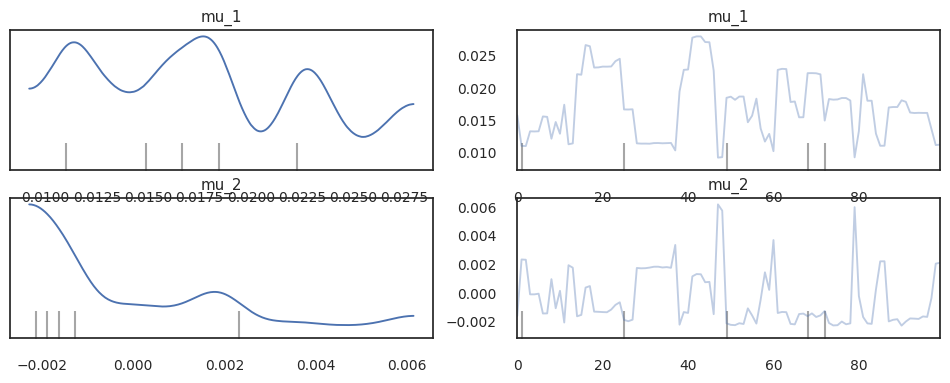

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [ ]:
posterior_samples

{'mu_1': tensor([0.0157, 0.0110, 0.0110, 0.0133, 0.0132, 0.0133, 0.0156, 0.0155, 0.0121,
         0.0147, 0.0129, 0.0174, 0.0112, 0.0114, 0.0221, 0.0220, 0.0266, 0.0264,
         0.0231, 0.0232, 0.0233, 0.0233, 0.0233, 0.0241, 0.0245, 0.0166, 0.0166,
         0.0167, 0.0114, 0.0113, 0.0114, 0.0113, 0.0114, 0.0114, 0.0114, 0.0114,
         0.0114, 0.0103, 0.0194, 0.0228, 0.0228, 0.0277, 0.0279, 0.0279, 0.0271,
         0.0270, 0.0226, 0.0092, 0.0092, 0.0184, 0.0186, 0.0181, 0.0186, 0.0186,
         0.0147, 0.0157, 0.0183, 0.0137, 0.0117, 0.0129, 0.0102, 0.0228, 0.0229,
         0.0229, 0.0178, 0.0179, 0.0154, 0.0154, 0.0223, 0.0223, 0.0222, 0.0221,
         0.0149, 0.0182, 0.0182, 0.0182, 0.0184, 0.0184, 0.0180, 0.0092, 0.0133,
         0.0221, 0.0180, 0.0180, 0.0129, 0.0110, 0.0110, 0.0169, 0.0170, 0.0170,
         0.0180, 0.0178, 0.0162, 0.0161, 0.0161, 0.0161, 0.0161, 0.0136, 0.0111,
         0.0112], dtype=torch.float64),
 'mu_2': tensor([-1.6176e-03,  2.3197e-03,  2.3014e-03, -1.12

In [ ]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data":
        mean = values.mean(dim=0)
        cov = values.std(dim=0)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov.detach().numpy())
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

mu_1
mean
 tensor(0.0171, dtype=torch.float64) 
std
 tensor(0.0050, dtype=torch.float64)
mu_2
mean
 tensor(-0.0004, dtype=torch.float64) 
std
 tensor(0.0020, dtype=torch.float64)


In [ ]:
loc_mean_posterior

[]

In [ ]:
loc_cov_posterior

[]

In [ ]:
# plt.figure(figsize=(8, 6))
# x = np.linspace(-0.5,1.5,8000)
#   # Combine x and y grids into a (100, 100, 2) array
# for i in range(3):
#     # Create a multivariate normal distribution
#     rv = norm(loc_mean_posterior[0][i], loc_cov_posterior[0][i])

#     # Calculate PDF values for each point in the grid
#     pdf_values = rv.pdf(x)

#     # Plot the Gaussian distribution using contour plot
    
#     plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
# #plt.colorbar(label='Probability Density')
# plt.xlabel('hsi_spectra')
# plt.ylabel('Unnormalized Probability Density')
# plt.title('Gaussian Distribution')
# #plt.scatter(loc_mean[i], color='red', label='Mean')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
data.posterior

<xarray.Dataset> Size: 2kB
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    mu_1     (chain, draw) float64 800B 0.01572 0.011 ... 0.01112 0.01119
    mu_2     (chain, draw) float64 800B -0.001618 0.00232 ... 0.002028 0.002089
Attributes:
    created_at:                 2024-07-16T18:49:32.769733+00:00
    arviz_version:              0.18.0
    inference_library:          pyro
    inference_library_version:  1.9.0

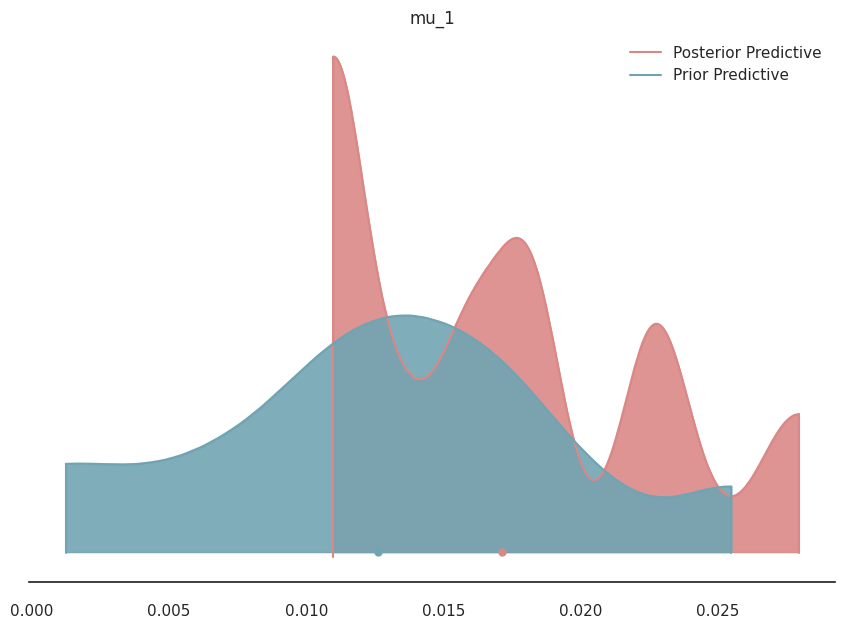

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

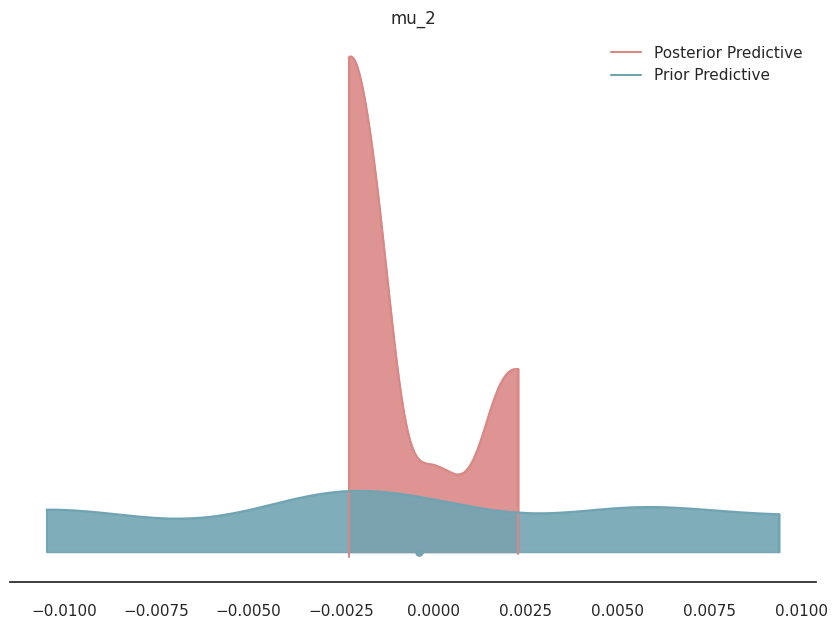

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 44062.28719388272.


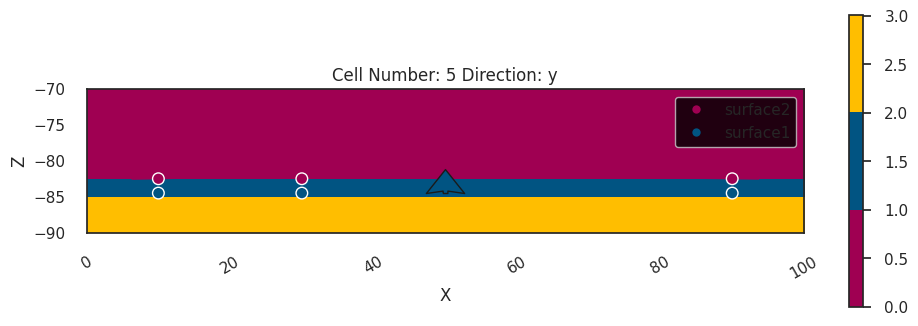

In [ ]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([2]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([5]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [ ]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-0.2500,  0.0000,  0.0125],
        [ 0.2500,  0.0000,  0.0125],
        [-0.1250,  0.0000,  0.0171],
        [-0.2500,  0.0000,  0.0000],
        [ 0.2500,  0.0000,  0.0000],
        [-0.1250,  0.0000, -0.0004]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [ ]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 10.        ,   0.        , -82.5       ],
       [ 90.        ,   0.        , -82.5       ],
       [ 30.        ,   0.        , -81.75910422],
       [ 10.        ,   0.        , -84.5       ],
       [ 90.        ,   0.        , -84.5       ],
       [ 30.        ,   0.        , -84.5620366 ]])

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy_engine/core/data/transforms.py:187: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(


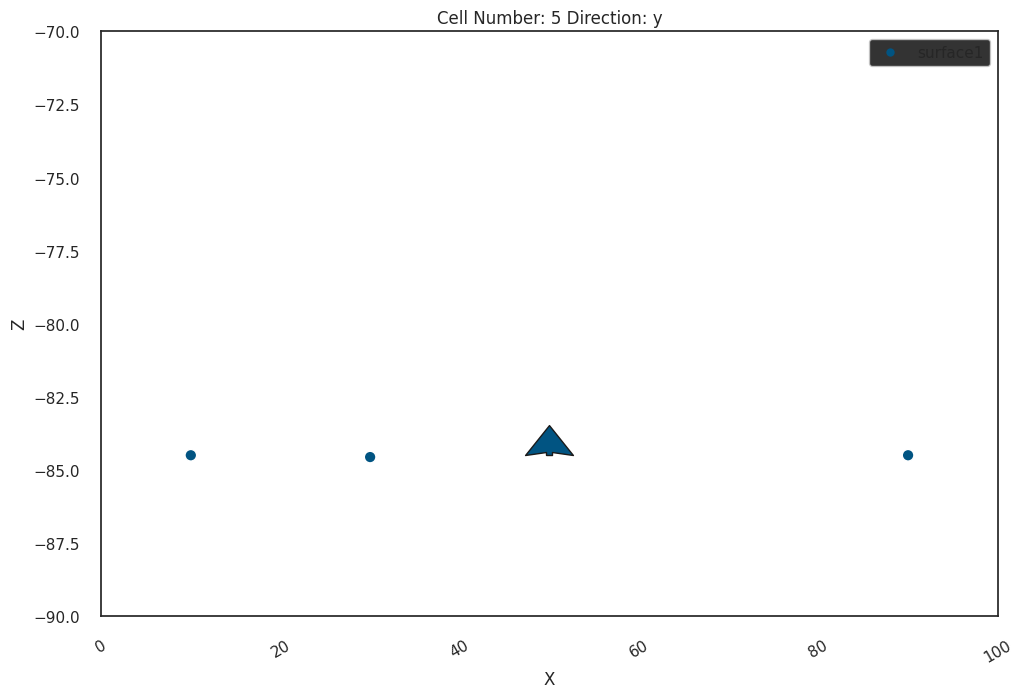

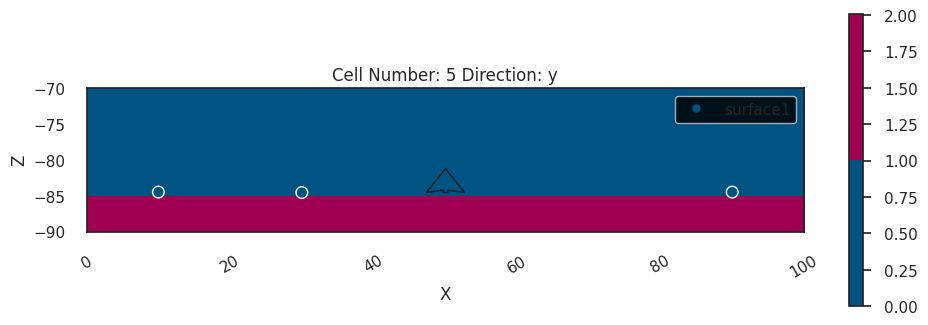

In [ ]:
geo_model_post = gp.create_geomodel(
    project_name='Gempy_post_Test',
    extent=[0, 100, -1, 1, -90, -70],
    resolution=[100,10,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
geo_model_post.interpolation_options.kernel_options.range=7
gp.add_surface_points(
    geo_model=geo_model_post,
    x=sp_cord[3:,0],
    y=sp_cord[3:,1],
    z=sp_cord[3:,2],
    elements_names=['surface1', 'surface1','surface1']
)
gp.add_orientations(
    geo_model=geo_model_post,
    x=[50],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1.0]]
)
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)  
gp.compute_model(geo_model_post, engine_config=gp.data.GemPyEngineConfig())
gpv.plot_2d(geo_model_post, cell_number=[5])
    

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy_engine/core/data/transforms.py:187: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(


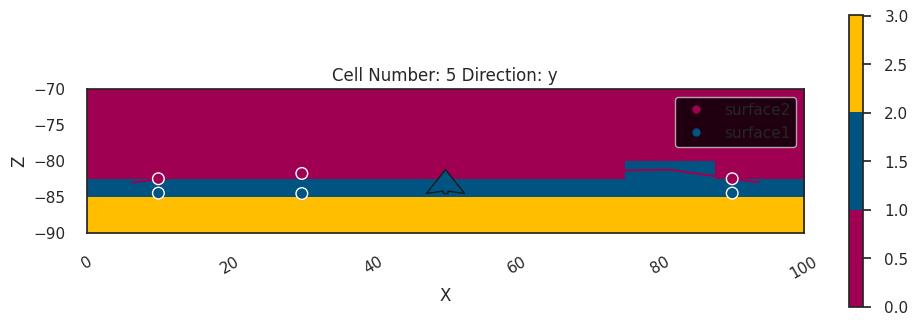

In [ ]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=sp_cord[0:3,0],
        y=sp_cord[0:3,1],
        z=sp_cord[0:3,2],
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)
geo_model_post.structural_frame.structural_groups[0].append_element(element2)
gp.compute_model(geo_model_post)
#gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_post.structural_frame.structural_groups[0].elements[0], geo_model_post.structural_frame.structural_groups[0].elements[1] = \
geo_model_post.structural_frame.structural_groups[0].elements[1], geo_model_post.structural_frame.structural_groups[0].elements[0]
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')


In [ ]:
geo_model_post.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,95431086,0.00
90.00,0.00,-82.50,95431086,0.00
30.00,0.00,-81.76,95431086,0.00
10.00,0.00,-84.50,48155407,0.00
90.00,0.00,-84.50,48155407,0.00
30.00,0.00,-84.56,48155407,0.00


In [ ]:
# # Creating marginal distribution plots
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 5), joyplot=False, marginal=True, likelihood=False)
# p.plot_marginal(
#     var_names=['mu_1', 'mu_2'],
#     plot_trace=False,
#     credible_interval=.70,
#     kind='kde',
#     marginal_kwargs={"bw": 1}
# )
# plt.show()

In [ ]:
# # Visualizing the posterior distributions
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 6), joyplot=True)
# iteration = 99
# p.plot_posterior(
#     prior_var=['mu_1', 'mu_2'],
#     like_var=['mu_1', 'mu_2'],
#     obs='obs',
#     iteration=iteration,
#     marginal_kwargs={
#         "credible_interval": 0.94,
#         'marginal_kwargs': {"bw": 1},
#         'joint_kwargs': {"bw": 1}
#     }
# )
# plt.show()

In [ ]:
# # Creating a pair plot for selected parameters
# az.plot_pair(data, divergences=False, var_names=['mu_1', 'mu_2'])
# plt.show()